In [1]:
'''
!pip install Cython
!git clone https://github.com/waleedka/coco.git

!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI
'''

'\n!pip install Cython\n!git clone https://github.com/waleedka/coco.git\n\n!pip install -U setuptools\n!pip install -U wheel\n!make install -C coco/PythonAPI\n'

In [2]:
import os
import sys
import random
import math
import numpy as np
import csv
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2
import imageio
import datetime
import tensorflow as tf
import keras
from keras.callbacks import LearningRateScheduler



# Root directory of the project
ROOT_DIR = os.path.abspath("../")
# Ignore Warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
print(ROOT_DIR)
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/interior/"))  # To find local version
sys.path.append('')  # To find local version
import projection1
import interior_seq

%matplotlib inline 
%load_ext tensorboard

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")
print('finished')

/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/erbachj/MaskRCNN/lib/python3.6/site-packages/tensorflow/python/framework/dty

/media/scratch1/erbachj/Mask_RCNN
The tensorboard module is not an IPython extension.
finished


In [3]:
def get_ax(rows=1, cols=1, size=13):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


In [5]:
class_names = ['BG', 'wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa',
               'table', 'door', 'window', 'bookshelf', 'picture', 'counter',
               'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 
               'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator',
               'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 
               'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 
               'otherstructure', 'otherfurniture', 'otherprop']

selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'curtain', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
# without curtain
selected_classes = ['BG', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'window', 
                    'picture', 'blinds', 'shelves', 'dresser', 'pillow', 
                    'mirror',  'clothes','books', 'refrigerator','television', 'paper', 'towel',
                    'toilet', 'sink', 'lamp', 'bathtub', 'bag']
print(class_names[15])

shelves


In [6]:
NYU40_to_sel_map = {}
selected_class_list = []

for i in range(len(class_names)):
    if class_names[i] in selected_classes:
        NYU40_to_sel_map[i] = selected_classes.index(class_names[i])
        selected_class_list.append(i)
    else:
        NYU40_to_sel_map[i] = 0
NYU40_to_sel_map[class_names.index('desk')] = selected_classes.index('table')
NYU40_to_sel_map[class_names.index('bookshelf')] = selected_classes.index('shelves')
NYU40_to_sel_map[class_names.index('refridgerator')] = selected_classes.index('refrigerator')
selected_class_list.append(class_names.index('desk'))
selected_class_list.append(class_names.index('bookshelf'))
selected_class_list.append(class_names.index('refridgerator'))

"""
NYU40_to_sel_map = {'BG': 'BG', 'wall': 'BG', 'floor': 'BG', 'cabinet': 'cabinet', 
                    'bed': 'bed', 'chair': 'chair', 'sofa': 'sofa', 'table': 'table', 
                    'door': 'BG', 'window': 'window', 'bookshelf': 'shelves', 
                    'picture': 'picture', 'counter': 'BG', 'blinds': 'blinds', 
                    'desk': 'table', 'shelves': 'shelves', 'curtain': 'curtain', 
                    'dresser': 'dresser', 'pillow': 'pillow', 'mirror': 'mirror', 
                    'clothes': 'clothes', 'ceiling': 'BG', 'books': 'books', 
                    'refridgerator': 'refrigerator', 'television': 'television', 
                    'paper': 'paper', 'towel': 'towel', 'shower': 'BG', 'box': 'BG', 
                    'whiteboard': 'BG', 'person': 'BG', 'night': 'BG', 'toilet': 'toilet',
                    'sink': 'sink', 'lamp': 'lamp', 'bathtub': 'bathtub', 'bag': 'bag', 
                    'otherstructure': 'BG', 'otherfurniture': 'BG', 'otherprop': 'BG'}
"""

print(NYU40_to_sel_map)
print(selected_class_list)

{0: 0, 1: 0, 2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 0, 9: 6, 10: 9, 11: 7, 12: 0, 13: 8, 14: 5, 15: 9, 16: 0, 17: 10, 18: 11, 19: 12, 20: 0, 21: 13, 22: 0, 23: 14, 24: 15, 25: 16, 26: 17, 27: 18, 28: 0, 29: 0, 30: 0, 31: 0, 32: 0, 33: 19, 34: 20, 35: 21, 36: 22, 37: 23, 38: 0, 39: 0, 40: 0}
[0, 3, 4, 5, 6, 7, 9, 11, 13, 15, 17, 18, 19, 21, 23, 25, 26, 27, 33, 34, 35, 36, 37, 14, 10, 24]


In [7]:
#TRAIN_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDDWIQX7_Dining_room'
#TRAIN_DIR = os.path.join(TRAIN_DIR,'cam0/data/')
TRAIN_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')
print(TRAIN_DIR)
# Training dataset
dataset_train = interior_seq.InteriorDataset()
dataset_train.load_Interior(dataset_dir=TRAIN_DIR, subset='train', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_train.prepare()

# Validation dataset
#VAL_DIR = '/home/erbachj/MaskRCNN/Mask_RCNN/data/InteriorNet/data/HD7/3FO4IDEI1LAV_Dining_room'
#VAL_DIR = os.path.join(VAL_DIR,'cam0/data/')
VAL_DIR = os.path.join(ROOT_DIR, 'data/InteriorNet/data/HD7')

dataset_val = interior_seq.InteriorDataset()
dataset_val.load_Interior(dataset_dir=VAL_DIR, subset='val', class_ids=selected_class_list, NYU40_to_sel_map=NYU40_to_sel_map,
                          selected_classes=selected_classes)
dataset_val.prepare()

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7
HD7
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4K9BL11ER_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4K9BL11ER_Guest_room_id0
3FO4K9BL11ER_Guest_room_id1
3FO4K9BL11ER_Guest_room_id2
3FO4K9BL11ER_Guest_room_id3
3FO4K9BL11ER_Guest_room_id4
3FO4K9BL11ER_Guest_room_id5
3FO4K9BL11ER_Guest_room_id6
3FO4K9BL11ER_Guest_room_id7
3FO4K9BL11ER_Guest_room_id8
3FO4K9BL11ER_Guest_room_id9
3FO4K9BL11ER_Guest_room_id12
3FO4K9BL11ER_Guest_room_id13
3FO4K9BL11ER_Guest_room_id14
3FO4K9BL11ER_Guest_room_id15
3FO4K9BL11ER_Guest_room_id16
3FO4K9BL11ER_Guest_room_id17
3FO4K9BL11ER_Guest_room_id18
3FO4K9BL11ER_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JJA8WOJP_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JJA8WOJP_Living_room_id0
3FO4JJA8WOJP_Living_room_id1
3FO4JJA8WOJP_Living

3FO4M4R5FORI_Living_room_id14
3FO4M4R5FORI_Living_room_id15
3FO4M4R5FORI_Living_room_id16
3FO4M4R5FORI_Living_room_id17
3FO4M4R5FORI_Living_room_id18
3FO4M4R5FORI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG7ETAT7_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG7ETAT7_Bedroom_id0
3FO4MG7ETAT7_Bedroom_id1
3FO4MG7ETAT7_Bedroom_id2
3FO4MG7ETAT7_Bedroom_id3
3FO4MG7ETAT7_Bedroom_id4
3FO4MG7ETAT7_Bedroom_id5
3FO4MG7ETAT7_Bedroom_id6
3FO4MG7ETAT7_Bedroom_id7
3FO4MG7ETAT7_Bedroom_id8
3FO4MG7ETAT7_Bedroom_id9
3FO4MG7ETAT7_Bedroom_id10
3FO4MG7ETAT7_Bedroom_id11
3FO4MG7ETAT7_Bedroom_id12
3FO4MG7ETAT7_Bedroom_id13
3FO4MG7ETAT7_Bedroom_id14
3FO4MG7ETAT7_Bedroom_id15
3FO4MG7ETAT7_Bedroom_id16
3FO4MG7ETAT7_Bedroom_id17
3FO4MG7ETAT7_Bedroom_id18
3FO4MG7ETAT7_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKG2MABN_Bedroom
loading annotations into memory...
Done (t=0.00s)
cre

3FO4JXMRWYF6_Guest_room_id0
3FO4JXMRWYF6_Guest_room_id1
3FO4JXMRWYF6_Guest_room_id2
3FO4JXMRWYF6_Guest_room_id3
3FO4JXMRWYF6_Guest_room_id4
3FO4JXMRWYF6_Guest_room_id5
3FO4JXMRWYF6_Guest_room_id6
3FO4JXMRWYF6_Guest_room_id7
3FO4JXMRWYF6_Guest_room_id8
3FO4JXMRWYF6_Guest_room_id9
3FO4JXMRWYF6_Guest_room_id10
3FO4JXMRWYF6_Guest_room_id11
3FO4JXMRWYF6_Guest_room_id12
3FO4JXMRWYF6_Guest_room_id13
3FO4JXMRWYF6_Guest_room_id14
3FO4JXMRWYF6_Guest_room_id15
3FO4JXMRWYF6_Guest_room_id16
3FO4JXMRWYF6_Guest_room_id17
3FO4JXMRWYF6_Guest_room_id18
3FO4JXMRWYF6_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJ98KARL_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJ98KARL_Living_room_id0
3FO4MJ98KARL_Living_room_id1
3FO4MJ98KARL_Living_room_id2
3FO4MJ98KARL_Living_room_id3
3FO4MJ98KARL_Living_room_id4
3FO4MJ98KARL_Living_room_id5
3FO4MJ98KARL_Living_room_id6
3FO4MJ98KARL_Living_room_id7
3FO4MJ98KARL_Living_room

3FO4MIBX7R1J_Bedroom_id5
3FO4MIBX7R1J_Bedroom_id6
3FO4MIBX7R1J_Bedroom_id7
3FO4MIBX7R1J_Bedroom_id8
3FO4MIBX7R1J_Bedroom_id9
3FO4MIBX7R1J_Bedroom_id10
3FO4MIBX7R1J_Bedroom_id11
3FO4MIBX7R1J_Bedroom_id12
3FO4MIBX7R1J_Bedroom_id13
3FO4MIBX7R1J_Bedroom_id14
3FO4MIBX7R1J_Bedroom_id15
3FO4MIBX7R1J_Bedroom_id16
3FO4MIBX7R1J_Bedroom_id17
3FO4MIBX7R1J_Bedroom_id18
3FO4MIBX7R1J_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLTARDRD_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLTARDRD_Bedroom_id0
3FO4MLTARDRD_Bedroom_id1
3FO4MLTARDRD_Bedroom_id2
3FO4MLTARDRD_Bedroom_id3
3FO4MLTARDRD_Bedroom_id4
3FO4MLTARDRD_Bedroom_id5
3FO4MLTARDRD_Bedroom_id6
3FO4MLTARDRD_Bedroom_id7
3FO4MLTARDRD_Bedroom_id8
3FO4MLTARDRD_Bedroom_id9
3FO4MLTARDRD_Bedroom_id10
3FO4MLTARDRD_Bedroom_id11
3FO4MLTARDRD_Bedroom_id12
3FO4MLTARDRD_Bedroom_id13
3FO4MLTARDRD_Bedroom_id14
3FO4MLTARDRD_Bedroom_id15
3FO4MLTARDRD_Bedroom_id16
3FO4MLTARDRD_

Done (t=0.00s)
creating index...
index created!
3FO4JXHV9Y5C_Guest_room_id0
3FO4JXHV9Y5C_Guest_room_id2
3FO4JXHV9Y5C_Guest_room_id3
3FO4JXHV9Y5C_Guest_room_id4
3FO4JXHV9Y5C_Guest_room_id5
3FO4JXHV9Y5C_Guest_room_id6
3FO4JXHV9Y5C_Guest_room_id7
3FO4JXHV9Y5C_Guest_room_id8
3FO4JXHV9Y5C_Guest_room_id9
3FO4JXHV9Y5C_Guest_room_id10
3FO4JXHV9Y5C_Guest_room_id12
3FO4JXHV9Y5C_Guest_room_id13
3FO4JXHV9Y5C_Guest_room_id16
3FO4JXHV9Y5C_Guest_room_id17
3FO4JXHV9Y5C_Guest_room_id18
3FO4JXHV9Y5C_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MAUYYN36_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MAUYYN36_Living_room_id0
3FO4MAUYYN36_Living_room_id1
3FO4MAUYYN36_Living_room_id2
3FO4MAUYYN36_Living_room_id3
3FO4MAUYYN36_Living_room_id5
3FO4MAUYYN36_Living_room_id6
3FO4MAUYYN36_Living_room_id7
3FO4MAUYYN36_Living_room_id8
3FO4MAUYYN36_Living_room_id9
3FO4MAUYYN36_Living_room_id10
3FO4MAUYYN36_Living_room_id11
3F

3FO4LOXAKCCK_Living_room_id9
3FO4LOXAKCCK_Living_room_id10
3FO4LOXAKCCK_Living_room_id11
3FO4LOXAKCCK_Living_room_id12
3FO4LOXAKCCK_Living_room_id13
3FO4LOXAKCCK_Living_room_id14
3FO4LOXAKCCK_Living_room_id15
3FO4LOXAKCCK_Living_room_id16
3FO4LOXAKCCK_Living_room_id17
3FO4LOXAKCCK_Living_room_id18
3FO4LOXAKCCK_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MFVGAV9M_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MFVGAV9M_Bedroom_id0
3FO4MFVGAV9M_Bedroom_id1
3FO4MFVGAV9M_Bedroom_id2
3FO4MFVGAV9M_Bedroom_id3
3FO4MFVGAV9M_Bedroom_id4
3FO4MFVGAV9M_Bedroom_id5
3FO4MFVGAV9M_Bedroom_id6
3FO4MFVGAV9M_Bedroom_id7
3FO4MFVGAV9M_Bedroom_id8
3FO4MFVGAV9M_Bedroom_id9
3FO4MFVGAV9M_Bedroom_id10
3FO4MFVGAV9M_Bedroom_id11
3FO4MFVGAV9M_Bedroom_id12
3FO4MFVGAV9M_Bedroom_id13
3FO4MFVGAV9M_Bedroom_id14
3FO4MFVGAV9M_Bedroom_id15
3FO4MFVGAV9M_Bedroom_id16
3FO4MFVGAV9M_Bedroom_id17
3FO4MFVGAV9M_Bedroom_id18
3FO4MFVGAV9M_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4JVY9QPES_Living_room_id0
3FO4JVY9QPES_Living_room_id1
3FO4JVY9QPES_Living_room_id2
3FO4JVY9QPES_Living_room_id3
3FO4JVY9QPES_Living_room_id4
3FO4JVY9QPES_Living_room_id5
3FO4JVY9QPES_Living_room_id6
3FO4JVY9QPES_Living_room_id7
3FO4JVY9QPES_Living_room_id8
3FO4JVY9QPES_Living_room_id9
3FO4JVY9QPES_Living_room_id10
3FO4JVY9QPES_Living_room_id11
3FO4JVY9QPES_Living_room_id12
3FO4JVY9QPES_Living_room_id13
3FO4JVY9QPES_Living_room_id14
3FO4JVY9QPES_Living_room_id15
3FO4JVY9QPES_Living_room_id16
3FO4JVY9QPES_Living_room_id17
3FO4JVY9QPES_Living_room_id18
3FO4JVY9QPES_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JV14MUMB_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JV14MUMB_Guest_room_id0
3FO4JV14MUMB_Guest_room_id1
3FO4JV14MUMB_Guest_room_id2
3FO4JV14MUMB_Guest_room_id3
3FO4JV14MUMB_Guest_room_id4
3FO4JV14MUMB_Guest_room_id5
3FO4JV14MUMB_Guest_ro

3FO4MBKAB0YY_Living_room_id12
3FO4MBKAB0YY_Living_room_id13
3FO4MBKAB0YY_Living_room_id14
3FO4MBKAB0YY_Living_room_id15
3FO4MBKAB0YY_Living_room_id16
3FO4MBKAB0YY_Living_room_id17
3FO4MBKAB0YY_Living_room_id18
3FO4MBKAB0YY_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M9U3NSUP_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M9U3NSUP_Living_room_id0
3FO4M9U3NSUP_Living_room_id1
3FO4M9U3NSUP_Living_room_id2
3FO4M9U3NSUP_Living_room_id3
3FO4M9U3NSUP_Living_room_id4
3FO4M9U3NSUP_Living_room_id5
3FO4M9U3NSUP_Living_room_id6
3FO4M9U3NSUP_Living_room_id7
3FO4M9U3NSUP_Living_room_id8
3FO4M9U3NSUP_Living_room_id9
3FO4M9U3NSUP_Living_room_id10
3FO4M9U3NSUP_Living_room_id11
3FO4M9U3NSUP_Living_room_id12
3FO4M9U3NSUP_Living_room_id13
3FO4M9U3NSUP_Living_room_id14
3FO4M9U3NSUP_Living_room_id15
3FO4M9U3NSUP_Living_room_id16
3FO4M9U3NSUP_Living_room_id17
3FO4M9U3NSUP_Living_room_id18
3FO4M9U3NSUP_Living_room_i

3FO4MKOTGB0E_Bedroom_id13
3FO4MKOTGB0E_Bedroom_id14
3FO4MKOTGB0E_Bedroom_id15
3FO4MKOTGB0E_Bedroom_id16
3FO4MKOTGB0E_Bedroom_id17
3FO4MKOTGB0E_Bedroom_id18
3FO4MKOTGB0E_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1TTN1IH_Living_room
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
3FO4M1TTN1IH_Living_room_id0
3FO4M1TTN1IH_Living_room_id1
3FO4M1TTN1IH_Living_room_id2
3FO4M1TTN1IH_Living_room_id3
3FO4M1TTN1IH_Living_room_id4
3FO4M1TTN1IH_Living_room_id5
3FO4M1TTN1IH_Living_room_id6
3FO4M1TTN1IH_Living_room_id7
3FO4M1TTN1IH_Living_room_id8
3FO4M1TTN1IH_Living_room_id9
3FO4M1TTN1IH_Living_room_id10
3FO4M1TTN1IH_Living_room_id11
3FO4M1TTN1IH_Living_room_id12
3FO4M1TTN1IH_Living_room_id13
3FO4M1TTN1IH_Living_room_id14
3FO4M1TTN1IH_Living_room_id15
3FO4M1TTN1IH_Living_room_id16
3FO4M1TTN1IH_Living_room_id17
3FO4M1TTN1IH_Living_room_id18
3FO4M1TTN1IH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/dat

creating index...
index created!
3FO4M043VBX0_Guest_room_id0
3FO4M043VBX0_Guest_room_id1
3FO4M043VBX0_Guest_room_id2
3FO4M043VBX0_Guest_room_id3
3FO4M043VBX0_Guest_room_id4
3FO4M043VBX0_Guest_room_id5
3FO4M043VBX0_Guest_room_id6
3FO4M043VBX0_Guest_room_id7
3FO4M043VBX0_Guest_room_id8
3FO4M043VBX0_Guest_room_id9
3FO4M043VBX0_Guest_room_id10
3FO4M043VBX0_Guest_room_id11
3FO4M043VBX0_Guest_room_id13
3FO4M043VBX0_Guest_room_id14
3FO4M043VBX0_Guest_room_id15
3FO4M043VBX0_Guest_room_id16
3FO4M043VBX0_Guest_room_id17
3FO4M043VBX0_Guest_room_id18
3FO4M043VBX0_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKIE9OL8_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKIE9OL8_Bedroom_id0
3FO4MKIE9OL8_Bedroom_id1
3FO4MKIE9OL8_Bedroom_id2
3FO4MKIE9OL8_Bedroom_id3
3FO4MKIE9OL8_Bedroom_id4
3FO4MKIE9OL8_Bedroom_id5
3FO4MKIE9OL8_Bedroom_id6
3FO4MKIE9OL8_Bedroom_id7
3FO4MKIE9OL8_Bedroom_id8
3FO4MKIE9OL8_Bedroom_id9
3FO4MK

Done (t=0.00s)
creating index...
index created!
3FO4IDF0MVC7_Dining_room_id0
3FO4IDF0MVC7_Dining_room_id1
3FO4IDF0MVC7_Dining_room_id2
3FO4IDF0MVC7_Dining_room_id3
3FO4IDF0MVC7_Dining_room_id4
3FO4IDF0MVC7_Dining_room_id5
3FO4IDF0MVC7_Dining_room_id6
3FO4IDF0MVC7_Dining_room_id7
3FO4IDF0MVC7_Dining_room_id8
3FO4IDF0MVC7_Dining_room_id9
3FO4IDF0MVC7_Dining_room_id10
3FO4IDF0MVC7_Dining_room_id11
3FO4IDF0MVC7_Dining_room_id12
3FO4IDF0MVC7_Dining_room_id13
3FO4IDF0MVC7_Dining_room_id14
3FO4IDF0MVC7_Dining_room_id15
3FO4IDF0MVC7_Dining_room_id16
3FO4IDF0MVC7_Dining_room_id17
3FO4IDF0MVC7_Dining_room_id18
3FO4IDF0MVC7_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKGBI8YN_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKGBI8YN_Bedroom_id0
3FO4MKGBI8YN_Bedroom_id1
3FO4MKGBI8YN_Bedroom_id2
3FO4MKGBI8YN_Bedroom_id3
3FO4MKGBI8YN_Bedroom_id4
3FO4MKGBI8YN_Bedroom_id5
3FO4MKGBI8YN_Bedroom_id6
3FO4MKGBI8YN_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4JVORQ7NF_Guest_room_id0
3FO4JVORQ7NF_Guest_room_id1
3FO4JVORQ7NF_Guest_room_id2
3FO4JVORQ7NF_Guest_room_id3
3FO4JVORQ7NF_Guest_room_id4
3FO4JVORQ7NF_Guest_room_id5
3FO4JVORQ7NF_Guest_room_id6
3FO4JVORQ7NF_Guest_room_id7
3FO4JVORQ7NF_Guest_room_id8
3FO4JVORQ7NF_Guest_room_id9
3FO4JVORQ7NF_Guest_room_id10
3FO4JVORQ7NF_Guest_room_id11
3FO4JVORQ7NF_Guest_room_id12
3FO4JVORQ7NF_Guest_room_id14
3FO4JVORQ7NF_Guest_room_id15
3FO4JVORQ7NF_Guest_room_id16
3FO4JVORQ7NF_Guest_room_id17
3FO4JVORQ7NF_Guest_room_id18
3FO4JVORQ7NF_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M3IG3CUY_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M3IG3CUY_Guest_room_id0
3FO4M3IG3CUY_Guest_room_id1
3FO4M3IG3CUY_Guest_room_id2
3FO4M3IG3CUY_Guest_room_id3
3FO4M3IG3CUY_Guest_room_id4
3FO4M3IG3CUY_Guest_room_id5
3FO4M3IG3CUY_Guest_room_id6
3FO4M3IG3CUY_Guest_room_id7
3FO4M3IG3CUY_G

3FO4JVYVJ2WS_Guest_room_id17
3FO4JVYVJ2WS_Guest_room_id18
3FO4JVYVJ2WS_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNWW1BY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNWW1BY_Bedroom_id0
3FO4MHNWW1BY_Bedroom_id1
3FO4MHNWW1BY_Bedroom_id2
3FO4MHNWW1BY_Bedroom_id3
3FO4MHNWW1BY_Bedroom_id4
3FO4MHNWW1BY_Bedroom_id5
3FO4MHNWW1BY_Bedroom_id6
3FO4MHNWW1BY_Bedroom_id7
3FO4MHNWW1BY_Bedroom_id8
3FO4MHNWW1BY_Bedroom_id9
3FO4MHNWW1BY_Bedroom_id10
3FO4MHNWW1BY_Bedroom_id11
3FO4MHNWW1BY_Bedroom_id12
3FO4MHNWW1BY_Bedroom_id13
3FO4MHNWW1BY_Bedroom_id14
3FO4MHNWW1BY_Bedroom_id15
3FO4MHNWW1BY_Bedroom_id16
3FO4MHNWW1BY_Bedroom_id17
3FO4MHNWW1BY_Bedroom_id18
3FO4MHNWW1BY_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M7DNW3MW_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M7DNW3MW_Living_room_id0
3FO4M7DNW3MW_Living_room_id1
3

3FO4MAV021NV_Living_room_id11
3FO4MAV021NV_Living_room_id12
3FO4MAV021NV_Living_room_id13
3FO4MAV021NV_Living_room_id14
3FO4MAV021NV_Living_room_id15
3FO4MAV021NV_Living_room_id16
3FO4MAV021NV_Living_room_id17
3FO4MAV021NV_Living_room_id18
3FO4MAV021NV_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LKPKSVD0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LKPKSVD0_Living_room_id1
3FO4LKPKSVD0_Living_room_id4
3FO4LKPKSVD0_Living_room_id7
3FO4LKPKSVD0_Living_room_id10
3FO4LKPKSVD0_Living_room_id11
3FO4LKPKSVD0_Living_room_id12
3FO4LKPKSVD0_Living_room_id13
3FO4LKPKSVD0_Living_room_id14
3FO4LKPKSVD0_Living_room_id15
3FO4LKPKSVD0_Living_room_id16
3FO4LKPKSVD0_Living_room_id17
3FO4LKPKSVD0_Living_room_id18
3FO4LKPKSVD0_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IWD9YN0X_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index crea

3FO4JUONM6GM_Guest_room_id16
3FO4JUONM6GM_Guest_room_id17
3FO4JUONM6GM_Guest_room_id18
3FO4JUONM6GM_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1TFFW8_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1TFFW8_Living_room_id0
3FO4MM1TFFW8_Living_room_id1
3FO4MM1TFFW8_Living_room_id2
3FO4MM1TFFW8_Living_room_id3
3FO4MM1TFFW8_Living_room_id4
3FO4MM1TFFW8_Living_room_id5
3FO4MM1TFFW8_Living_room_id6
3FO4MM1TFFW8_Living_room_id7
3FO4MM1TFFW8_Living_room_id8
3FO4MM1TFFW8_Living_room_id9
3FO4MM1TFFW8_Living_room_id10
3FO4MM1TFFW8_Living_room_id11
3FO4MM1TFFW8_Living_room_id12
3FO4MM1TFFW8_Living_room_id13
3FO4MM1TFFW8_Living_room_id14
3FO4MM1TFFW8_Living_room_id15
3FO4MM1TFFW8_Living_room_id16
3FO4MM1TFFW8_Living_room_id17
3FO4MM1TFFW8_Living_room_id18
3FO4MM1TFFW8_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6QOT6TI_Dining_room
loading annotations into memo

3FO4MIHO27UU_Bedroom_id0
3FO4MIHO27UU_Bedroom_id1
3FO4MIHO27UU_Bedroom_id2
3FO4MIHO27UU_Bedroom_id3
3FO4MIHO27UU_Bedroom_id4
3FO4MIHO27UU_Bedroom_id5
3FO4MIHO27UU_Bedroom_id6
3FO4MIHO27UU_Bedroom_id7
3FO4MIHO27UU_Bedroom_id8
3FO4MIHO27UU_Bedroom_id9
3FO4MIHO27UU_Bedroom_id10
3FO4MIHO27UU_Bedroom_id11
3FO4MIHO27UU_Bedroom_id12
3FO4MIHO27UU_Bedroom_id13
3FO4MIHO27UU_Bedroom_id14
3FO4MIHO27UU_Bedroom_id15
3FO4MIHO27UU_Bedroom_id16
3FO4MIHO27UU_Bedroom_id17
3FO4MIHO27UU_Bedroom_id18
3FO4MIHO27UU_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IXYL1S83_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IXYL1S83_Living_room_id0
3FO4IXYL1S83_Living_room_id1
3FO4IXYL1S83_Living_room_id2
3FO4IXYL1S83_Living_room_id3
3FO4IXYL1S83_Living_room_id4
3FO4IXYL1S83_Living_room_id5
3FO4IXYL1S83_Living_room_id6
3FO4IXYL1S83_Living_room_id7
3FO4IXYL1S83_Living_room_id8
3FO4IXYL1S83_Living_room_id9
3FO4IXYL1S83_Living_room_i

3FO4MI9EPNHA_Living_room_id10
3FO4MI9EPNHA_Living_room_id11
3FO4MI9EPNHA_Living_room_id12
3FO4MI9EPNHA_Living_room_id13
3FO4MI9EPNHA_Living_room_id14
3FO4MI9EPNHA_Living_room_id15
3FO4MI9EPNHA_Living_room_id16
3FO4MI9EPNHA_Living_room_id17
3FO4MI9EPNHA_Living_room_id18
3FO4MI9EPNHA_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LR7IHQV9_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LR7IHQV9_Living_room_id0
3FO4LR7IHQV9_Living_room_id1
3FO4LR7IHQV9_Living_room_id2
3FO4LR7IHQV9_Living_room_id3
3FO4LR7IHQV9_Living_room_id4
3FO4LR7IHQV9_Living_room_id5
3FO4LR7IHQV9_Living_room_id6
3FO4LR7IHQV9_Living_room_id7
3FO4LR7IHQV9_Living_room_id8
3FO4LR7IHQV9_Living_room_id9
3FO4LR7IHQV9_Living_room_id10
3FO4LR7IHQV9_Living_room_id11
3FO4LR7IHQV9_Living_room_id12
3FO4LR7IHQV9_Living_room_id13
3FO4LR7IHQV9_Living_room_id14
3FO4LR7IHQV9_Living_room_id15
3FO4LR7IHQV9_Living_room_id16
3FO4LR7IHQV9_Living_room_i

Done (t=0.11s)
creating index...
index created!
3FO4JRDJS50D_Living_room_id0
3FO4JRDJS50D_Living_room_id1
3FO4JRDJS50D_Living_room_id2
3FO4JRDJS50D_Living_room_id3
3FO4JRDJS50D_Living_room_id4
3FO4JRDJS50D_Living_room_id5
3FO4JRDJS50D_Living_room_id6
3FO4JRDJS50D_Living_room_id7
3FO4JRDJS50D_Living_room_id8
3FO4JRDJS50D_Living_room_id9
3FO4JRDJS50D_Living_room_id10
3FO4JRDJS50D_Living_room_id11
3FO4JRDJS50D_Living_room_id12
3FO4JRDJS50D_Living_room_id13
3FO4JRDJS50D_Living_room_id14
3FO4JRDJS50D_Living_room_id15
3FO4JRDJS50D_Living_room_id16
3FO4JRDJS50D_Living_room_id17
3FO4JRDJS50D_Living_room_id18
3FO4JRDJS50D_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JT5Q1CG6_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JT5Q1CG6_Guest_room_id0
3FO4JT5Q1CG6_Guest_room_id1
3FO4JT5Q1CG6_Guest_room_id2
3FO4JT5Q1CG6_Guest_room_id3
3FO4JT5Q1CG6_Guest_room_id4
3FO4JT5Q1CG6_Guest_room_id5
3FO4JT5Q1CG6_Guest_ro

3FO4JDB4BWRN_Dining_room_id13
3FO4JDB4BWRN_Dining_room_id14
3FO4JDB4BWRN_Dining_room_id15
3FO4JDB4BWRN_Dining_room_id16
3FO4JDB4BWRN_Dining_room_id17
3FO4JDB4BWRN_Dining_room_id18
3FO4JDB4BWRN_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1764M48_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M1764M48_Guest_room_id0
3FO4M1764M48_Guest_room_id1
3FO4M1764M48_Guest_room_id2
3FO4M1764M48_Guest_room_id3
3FO4M1764M48_Guest_room_id4
3FO4M1764M48_Guest_room_id6
3FO4M1764M48_Guest_room_id7
3FO4M1764M48_Guest_room_id8
3FO4M1764M48_Guest_room_id9
3FO4M1764M48_Guest_room_id10
3FO4M1764M48_Guest_room_id11
3FO4M1764M48_Guest_room_id12
3FO4M1764M48_Guest_room_id13
3FO4M1764M48_Guest_room_id14
3FO4M1764M48_Guest_room_id15
3FO4M1764M48_Guest_room_id16
3FO4M1764M48_Guest_room_id17
3FO4M1764M48_Guest_room_id18
3FO4M1764M48_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1J1C

Done (t=0.00s)
creating index...
index created!
3FO4JVY9PNMH_Living_room_id0
3FO4JVY9PNMH_Living_room_id1
3FO4JVY9PNMH_Living_room_id3
3FO4JVY9PNMH_Living_room_id4
3FO4JVY9PNMH_Living_room_id5
3FO4JVY9PNMH_Living_room_id6
3FO4JVY9PNMH_Living_room_id7
3FO4JVY9PNMH_Living_room_id8
3FO4JVY9PNMH_Living_room_id9
3FO4JVY9PNMH_Living_room_id10
3FO4JVY9PNMH_Living_room_id11
3FO4JVY9PNMH_Living_room_id12
3FO4JVY9PNMH_Living_room_id13
3FO4JVY9PNMH_Living_room_id14
3FO4JVY9PNMH_Living_room_id15
3FO4JVY9PNMH_Living_room_id16
3FO4JVY9PNMH_Living_room_id17
3FO4JVY9PNMH_Living_room_id18
3FO4JVY9PNMH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBK7YC5J_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBK7YC5J_Living_room_id0
3FO4MBK7YC5J_Living_room_id1
3FO4MBK7YC5J_Living_room_id2
3FO4MBK7YC5J_Living_room_id3
3FO4MBK7YC5J_Living_room_id4
3FO4MBK7YC5J_Living_room_id5
3FO4MBK7YC5J_Living_room_id6
3FO4MBK7YC5J_L

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4KB44GGRC_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KB44GGRC_Guest_room_id0
3FO4KB44GGRC_Guest_room_id1
3FO4KB44GGRC_Guest_room_id2
3FO4KB44GGRC_Guest_room_id3
3FO4KB44GGRC_Guest_room_id4
3FO4KB44GGRC_Guest_room_id5
3FO4KB44GGRC_Guest_room_id6
3FO4KB44GGRC_Guest_room_id7
3FO4KB44GGRC_Guest_room_id8
3FO4KB44GGRC_Guest_room_id9
3FO4KB44GGRC_Guest_room_id10
3FO4KB44GGRC_Guest_room_id11
3FO4KB44GGRC_Guest_room_id12
3FO4KB44GGRC_Guest_room_id13
3FO4KB44GGRC_Guest_room_id14
3FO4KB44GGRC_Guest_room_id15
3FO4KB44GGRC_Guest_room_id16
3FO4KB44GGRC_Guest_room_id17
3FO4KB44GGRC_Guest_room_id18
3FO4KB44GGRC_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IV9VI5A4_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IV9VI5A4_Living_room_id0
3FO4IV9VI5A4_Living_room_id1
3FO4IV9VI5A4_Living_room_

3FO4MKG2W82M_Living_room_id15
3FO4MKG2W82M_Living_room_id16
3FO4MKG2W82M_Living_room_id17
3FO4MKG2W82M_Living_room_id18
3FO4MKG2W82M_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J8AUE7KI_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J8AUE7KI_Living_room_id0
3FO4J8AUE7KI_Living_room_id1
3FO4J8AUE7KI_Living_room_id2
3FO4J8AUE7KI_Living_room_id3
3FO4J8AUE7KI_Living_room_id4
3FO4J8AUE7KI_Living_room_id5
3FO4J8AUE7KI_Living_room_id6
3FO4J8AUE7KI_Living_room_id7
3FO4J8AUE7KI_Living_room_id8
3FO4J8AUE7KI_Living_room_id9
3FO4J8AUE7KI_Living_room_id10
3FO4J8AUE7KI_Living_room_id11
3FO4J8AUE7KI_Living_room_id12
3FO4J8AUE7KI_Living_room_id13
3FO4J8AUE7KI_Living_room_id14
3FO4J8AUE7KI_Living_room_id15
3FO4J8AUE7KI_Living_room_id16
3FO4J8AUE7KI_Living_room_id17
3FO4J8AUE7KI_Living_room_id18
3FO4J8AUE7KI_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MD4YMHX9_Living_

Done (t=0.00s)
creating index...
index created!
3FO4M2MBLIYS_Living_room_id0
3FO4M2MBLIYS_Living_room_id1
3FO4M2MBLIYS_Living_room_id2
3FO4M2MBLIYS_Living_room_id3
3FO4M2MBLIYS_Living_room_id4
3FO4M2MBLIYS_Living_room_id5
3FO4M2MBLIYS_Living_room_id6
3FO4M2MBLIYS_Living_room_id7
3FO4M2MBLIYS_Living_room_id8
3FO4M2MBLIYS_Living_room_id9
3FO4M2MBLIYS_Living_room_id10
3FO4M2MBLIYS_Living_room_id11
3FO4M2MBLIYS_Living_room_id12
3FO4M2MBLIYS_Living_room_id13
3FO4M2MBLIYS_Living_room_id14
3FO4M2MBLIYS_Living_room_id15
3FO4M2MBLIYS_Living_room_id16
3FO4M2MBLIYS_Living_room_id17
3FO4M2MBLIYS_Living_room_id18
3FO4M2MBLIYS_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J0KKMLN7_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J0KKMLN7_Dining_room_id0
3FO4J0KKMLN7_Dining_room_id1
3FO4J0KKMLN7_Dining_room_id2
3FO4J0KKMLN7_Dining_room_id3
3FO4J0KKMLN7_Dining_room_id4
3FO4J0KKMLN7_Dining_room_id5
3FO4J0KKMLN7_D

Done (t=0.00s)
creating index...
index created!
3FO4M83EAILC_Living_room_id0
3FO4M83EAILC_Living_room_id1
3FO4M83EAILC_Living_room_id2
3FO4M83EAILC_Living_room_id3
3FO4M83EAILC_Living_room_id4
3FO4M83EAILC_Living_room_id5
3FO4M83EAILC_Living_room_id6
3FO4M83EAILC_Living_room_id7
3FO4M83EAILC_Living_room_id8
3FO4M83EAILC_Living_room_id9
3FO4M83EAILC_Living_room_id10
3FO4M83EAILC_Living_room_id11
3FO4M83EAILC_Living_room_id12
3FO4M83EAILC_Living_room_id13
3FO4M83EAILC_Living_room_id14
3FO4M83EAILC_Living_room_id15
3FO4M83EAILC_Living_room_id16
3FO4M83EAILC_Living_room_id17
3FO4M83EAILC_Living_room_id18
3FO4M83EAILC_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LO08YMJW_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LO08YMJW_Living_room_id0
3FO4LO08YMJW_Living_room_id1
3FO4LO08YMJW_Living_room_id2
3FO4LO08YMJW_Living_room_id3
3FO4LO08YMJW_Living_room_id4
3FO4LO08YMJW_Living_room_id5
3FO4LO08YMJW_L

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXTBTF2_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXTBTF2_Bedroom_id0
3FO4MLXTBTF2_Bedroom_id1
3FO4MLXTBTF2_Bedroom_id2
3FO4MLXTBTF2_Bedroom_id3
3FO4MLXTBTF2_Bedroom_id4
3FO4MLXTBTF2_Bedroom_id5
3FO4MLXTBTF2_Bedroom_id6
3FO4MLXTBTF2_Bedroom_id7
3FO4MLXTBTF2_Bedroom_id8
3FO4MLXTBTF2_Bedroom_id9
3FO4MLXTBTF2_Bedroom_id10
3FO4MLXTBTF2_Bedroom_id11
3FO4MLXTBTF2_Bedroom_id12
3FO4MLXTBTF2_Bedroom_id13
3FO4MLXTBTF2_Bedroom_id14
3FO4MLXTBTF2_Bedroom_id15
3FO4MLXTBTF2_Bedroom_id16
3FO4MLXTBTF2_Bedroom_id17
3FO4MLXTBTF2_Bedroom_id18
3FO4MLXTBTF2_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J3HS1SQS_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J3HS1SQS_Living_room_id0
3FO4J3HS1SQS_Living_room_id1
3FO4J3HS1SQS_Living_room_id2
3FO4J3HS1SQS_Living_room_id3
3FO4J3HS1SQS_Living_room_id4
3

Done (t=0.00s)
creating index...
index created!
3FO4IGB7WUE6_Dining_room_id0
3FO4IGB7WUE6_Dining_room_id1
3FO4IGB7WUE6_Dining_room_id2
3FO4IGB7WUE6_Dining_room_id3
3FO4IGB7WUE6_Dining_room_id4
3FO4IGB7WUE6_Dining_room_id5
3FO4IGB7WUE6_Dining_room_id6
3FO4IGB7WUE6_Dining_room_id7
3FO4IGB7WUE6_Dining_room_id8
3FO4IGB7WUE6_Dining_room_id9
3FO4IGB7WUE6_Dining_room_id10
3FO4IGB7WUE6_Dining_room_id11
3FO4IGB7WUE6_Dining_room_id12
3FO4IGB7WUE6_Dining_room_id13
3FO4IGB7WUE6_Dining_room_id14
3FO4IGB7WUE6_Dining_room_id15
3FO4IGB7WUE6_Dining_room_id16
3FO4IGB7WUE6_Dining_room_id17
3FO4IGB7WUE6_Dining_room_id18
3FO4IGB7WUE6_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHGOWHXT_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHGOWHXT_Bedroom_id0
3FO4MHGOWHXT_Bedroom_id1
3FO4MHGOWHXT_Bedroom_id2
3FO4MHGOWHXT_Bedroom_id3
3FO4MHGOWHXT_Bedroom_id4
3FO4MHGOWHXT_Bedroom_id5
3FO4MHGOWHXT_Bedroom_id6
3FO4MHGOWHXT_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4MIHPK8LP_Living_room_id0
3FO4MIHPK8LP_Living_room_id1
3FO4MIHPK8LP_Living_room_id2
3FO4MIHPK8LP_Living_room_id3
3FO4MIHPK8LP_Living_room_id4
3FO4MIHPK8LP_Living_room_id5
3FO4MIHPK8LP_Living_room_id6
3FO4MIHPK8LP_Living_room_id7
3FO4MIHPK8LP_Living_room_id8
3FO4MIHPK8LP_Living_room_id9
3FO4MIHPK8LP_Living_room_id10
3FO4MIHPK8LP_Living_room_id11
3FO4MIHPK8LP_Living_room_id12
3FO4MIHPK8LP_Living_room_id13
3FO4MIHPK8LP_Living_room_id14
3FO4MIHPK8LP_Living_room_id15
3FO4MIHPK8LP_Living_room_id16
3FO4MIHPK8LP_Living_room_id17
3FO4MIHPK8LP_Living_room_id18
3FO4MIHPK8LP_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1YJXNW_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1YJXNW_Bedroom_id0
3FO4MM1YJXNW_Bedroom_id1
3FO4MM1YJXNW_Bedroom_id2
3FO4MM1YJXNW_Bedroom_id3
3FO4MM1YJXNW_Bedroom_id4
3FO4MM1YJXNW_Bedroom_id5
3FO4MM1YJXNW_Bedroom_id6
3FO4MM1YJXNW_Bedr

3FO4IXKDBTF9_Living_room_id14
3FO4IXKDBTF9_Living_room_id15
3FO4IXKDBTF9_Living_room_id16
3FO4IXKDBTF9_Living_room_id17
3FO4IXKDBTF9_Living_room_id18
3FO4IXKDBTF9_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIBWUCCT_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIBWUCCT_Bedroom_id0
3FO4MIBWUCCT_Bedroom_id2
3FO4MIBWUCCT_Bedroom_id3
3FO4MIBWUCCT_Bedroom_id4
3FO4MIBWUCCT_Bedroom_id5
3FO4MIBWUCCT_Bedroom_id6
3FO4MIBWUCCT_Bedroom_id7
3FO4MIBWUCCT_Bedroom_id8
3FO4MIBWUCCT_Bedroom_id9
3FO4MIBWUCCT_Bedroom_id10
3FO4MIBWUCCT_Bedroom_id11
3FO4MIBWUCCT_Bedroom_id12
3FO4MIBWUCCT_Bedroom_id13
3FO4MIBWUCCT_Bedroom_id14
3FO4MIBWUCCT_Bedroom_id15
3FO4MIBWUCCT_Bedroom_id16
3FO4MIBWUCCT_Bedroom_id17
3FO4MIBWUCCT_Bedroom_id18
3FO4MIBWUCCT_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MD6K19G3_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index c

3FO4JVLV5G50_Living_room_id9
3FO4JVLV5G50_Living_room_id10
3FO4JVLV5G50_Living_room_id11
3FO4JVLV5G50_Living_room_id12
3FO4JVLV5G50_Living_room_id13
3FO4JVLV5G50_Living_room_id14
3FO4JVLV5G50_Living_room_id15
3FO4JVLV5G50_Living_room_id16
3FO4JVLV5G50_Living_room_id17
3FO4JVLV5G50_Living_room_id18
3FO4JVLV5G50_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6RRT449_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6RRT449_Living_room_id1
3FO4M6RRT449_Living_room_id2
3FO4M6RRT449_Living_room_id3
3FO4M6RRT449_Living_room_id4
3FO4M6RRT449_Living_room_id5
3FO4M6RRT449_Living_room_id6
3FO4M6RRT449_Living_room_id7
3FO4M6RRT449_Living_room_id8
3FO4M6RRT449_Living_room_id9
3FO4M6RRT449_Living_room_id10
3FO4M6RRT449_Living_room_id11
3FO4M6RRT449_Living_room_id12
3FO4M6RRT449_Living_room_id13
3FO4M6RRT449_Living_room_id14
3FO4M6RRT449_Living_room_id15
3FO4M6RRT449_Living_room_id16
3FO4M6RRT449_Living_room_i

Done (t=0.00s)
creating index...
index created!
3FO4JAYNOAHF_Living_room_id0
3FO4JAYNOAHF_Living_room_id1
3FO4JAYNOAHF_Living_room_id2
3FO4JAYNOAHF_Living_room_id3
3FO4JAYNOAHF_Living_room_id4
3FO4JAYNOAHF_Living_room_id5
3FO4JAYNOAHF_Living_room_id6
3FO4JAYNOAHF_Living_room_id8
3FO4JAYNOAHF_Living_room_id10
3FO4JAYNOAHF_Living_room_id11
3FO4JAYNOAHF_Living_room_id12
3FO4JAYNOAHF_Living_room_id13
3FO4JAYNOAHF_Living_room_id14
3FO4JAYNOAHF_Living_room_id16
3FO4JAYNOAHF_Living_room_id17
3FO4JAYNOAHF_Living_room_id18
3FO4JAYNOAHF_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHP8AN5_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHP8AN5_Bedroom_id0
3FO4MIHP8AN5_Bedroom_id1
3FO4MIHP8AN5_Bedroom_id2
3FO4MIHP8AN5_Bedroom_id3
3FO4MIHP8AN5_Bedroom_id4
3FO4MIHP8AN5_Bedroom_id5
3FO4MIHP8AN5_Bedroom_id6
3FO4MIHP8AN5_Bedroom_id7
3FO4MIHP8AN5_Bedroom_id8
3FO4MIHP8AN5_Bedroom_id9
3FO4MIHP8AN5_Bedroom_id10
3FO4

3FO4J0DO6ILP_Living_room_id9
3FO4J0DO6ILP_Living_room_id10
3FO4J0DO6ILP_Living_room_id11
3FO4J0DO6ILP_Living_room_id12
3FO4J0DO6ILP_Living_room_id13
3FO4J0DO6ILP_Living_room_id14
3FO4J0DO6ILP_Living_room_id15
3FO4J0DO6ILP_Living_room_id16
3FO4J0DO6ILP_Living_room_id17
3FO4J0DO6ILP_Living_room_id18
3FO4J0DO6ILP_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4K9JMAXN4_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4K9JMAXN4_Guest_room_id0
3FO4K9JMAXN4_Guest_room_id1
3FO4K9JMAXN4_Guest_room_id2
3FO4K9JMAXN4_Guest_room_id3
3FO4K9JMAXN4_Guest_room_id4
3FO4K9JMAXN4_Guest_room_id5
3FO4K9JMAXN4_Guest_room_id6
3FO4K9JMAXN4_Guest_room_id7
3FO4K9JMAXN4_Guest_room_id8
3FO4K9JMAXN4_Guest_room_id9
3FO4K9JMAXN4_Guest_room_id10
3FO4K9JMAXN4_Guest_room_id11
3FO4K9JMAXN4_Guest_room_id12
3FO4K9JMAXN4_Guest_room_id13
3FO4K9JMAXN4_Guest_room_id14
3FO4K9JMAXN4_Guest_room_id15
3FO4K9JMAXN4_Guest_room_id16
3FO4K9JMAXN4_Gu

3FO4MG5BU4DB_Bedroom_id10
3FO4MG5BU4DB_Bedroom_id11
3FO4MG5BU4DB_Bedroom_id12
3FO4MG5BU4DB_Bedroom_id13
3FO4MG5BU4DB_Bedroom_id14
3FO4MG5BU4DB_Bedroom_id15
3FO4MG5BU4DB_Bedroom_id16
3FO4MG5BU4DB_Bedroom_id17
3FO4MG5BU4DB_Bedroom_id18
3FO4MG5BU4DB_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M4AXY8TY_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M4AXY8TY_Living_room_id0
3FO4M4AXY8TY_Living_room_id1
3FO4M4AXY8TY_Living_room_id2
3FO4M4AXY8TY_Living_room_id3
3FO4M4AXY8TY_Living_room_id4
3FO4M4AXY8TY_Living_room_id5
3FO4M4AXY8TY_Living_room_id6
3FO4M4AXY8TY_Living_room_id7
3FO4M4AXY8TY_Living_room_id8
3FO4M4AXY8TY_Living_room_id9
3FO4M4AXY8TY_Living_room_id10
3FO4M4AXY8TY_Living_room_id11
3FO4M4AXY8TY_Living_room_id12
3FO4M4AXY8TY_Living_room_id13
3FO4M4AXY8TY_Living_room_id14
3FO4M4AXY8TY_Living_room_id15
3FO4M4AXY8TY_Living_room_id16
3FO4M4AXY8TY_Living_room_id17
3FO4M4AXY8TY_Living_room_id18
3FO4M4

3FO4J967W2MD_Living_room_id14
3FO4J967W2MD_Living_room_id15
3FO4J967W2MD_Living_room_id16
3FO4J967W2MD_Living_room_id17
3FO4J967W2MD_Living_room_id18
3FO4J967W2MD_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JTRTS70L_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JTRTS70L_Guest_room_id0
3FO4JTRTS70L_Guest_room_id1
3FO4JTRTS70L_Guest_room_id2
3FO4JTRTS70L_Guest_room_id3
3FO4JTRTS70L_Guest_room_id4
3FO4JTRTS70L_Guest_room_id5
3FO4JTRTS70L_Guest_room_id6
3FO4JTRTS70L_Guest_room_id7
3FO4JTRTS70L_Guest_room_id8
3FO4JTRTS70L_Guest_room_id9
3FO4JTRTS70L_Guest_room_id10
3FO4JTRTS70L_Guest_room_id11
3FO4JTRTS70L_Guest_room_id12
3FO4JTRTS70L_Guest_room_id13
3FO4JTRTS70L_Guest_room_id14
3FO4JTRTS70L_Guest_room_id15
3FO4JTRTS70L_Guest_room_id16
3FO4JTRTS70L_Guest_room_id17
3FO4JTRTS70L_Guest_room_id18
3FO4JTRTS70L_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKOU5NM

Done (t=0.13s)
creating index...
index created!
3FO4J5H1419A_Living_room_id0
3FO4J5H1419A_Living_room_id1
3FO4J5H1419A_Living_room_id2
3FO4J5H1419A_Living_room_id3
3FO4J5H1419A_Living_room_id4
3FO4J5H1419A_Living_room_id5
3FO4J5H1419A_Living_room_id6
3FO4J5H1419A_Living_room_id7
3FO4J5H1419A_Living_room_id8
3FO4J5H1419A_Living_room_id9
3FO4J5H1419A_Living_room_id10
3FO4J5H1419A_Living_room_id11
3FO4J5H1419A_Living_room_id12
3FO4J5H1419A_Living_room_id13
3FO4J5H1419A_Living_room_id14
3FO4J5H1419A_Living_room_id15
3FO4J5H1419A_Living_room_id16
3FO4J5H1419A_Living_room_id17
3FO4J5H1419A_Living_room_id18
3FO4J5H1419A_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LOLCM2DN_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LOLCM2DN_Living_room_id0
3FO4LOLCM2DN_Living_room_id1
3FO4LOLCM2DN_Living_room_id2
3FO4LOLCM2DN_Living_room_id3
3FO4LOLCM2DN_Living_room_id4
3FO4LOLCM2DN_Living_room_id5
3FO4LOLCM2DN_L

Done (t=0.00s)
creating index...
index created!
3FO4MB9KKBEF_Living_room_id0
3FO4MB9KKBEF_Living_room_id1
3FO4MB9KKBEF_Living_room_id2
3FO4MB9KKBEF_Living_room_id3
3FO4MB9KKBEF_Living_room_id4
3FO4MB9KKBEF_Living_room_id5
3FO4MB9KKBEF_Living_room_id6
3FO4MB9KKBEF_Living_room_id7
3FO4MB9KKBEF_Living_room_id8
3FO4MB9KKBEF_Living_room_id9
3FO4MB9KKBEF_Living_room_id10
3FO4MB9KKBEF_Living_room_id11
3FO4MB9KKBEF_Living_room_id12
3FO4MB9KKBEF_Living_room_id13
3FO4MB9KKBEF_Living_room_id14
3FO4MB9KKBEF_Living_room_id15
3FO4MB9KKBEF_Living_room_id16
3FO4MB9KKBEF_Living_room_id17
3FO4MB9KKBEF_Living_room_id18
3FO4MB9KKBEF_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JWQ07E4M_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JWQ07E4M_Guest_room_id0
3FO4JWQ07E4M_Guest_room_id1
3FO4JWQ07E4M_Guest_room_id2
3FO4JWQ07E4M_Guest_room_id3
3FO4JWQ07E4M_Guest_room_id4
3FO4JWQ07E4M_Guest_room_id5
3FO4JWQ07E4M_Guest_ro

3FO4MMHCG9OC_Bedroom_id2
3FO4MMHCG9OC_Bedroom_id3
3FO4MMHCG9OC_Bedroom_id4
3FO4MMHCG9OC_Bedroom_id5
3FO4MMHCG9OC_Bedroom_id6
3FO4MMHCG9OC_Bedroom_id7
3FO4MMHCG9OC_Bedroom_id8
3FO4MMHCG9OC_Bedroom_id9
3FO4MMHCG9OC_Bedroom_id10
3FO4MMHCG9OC_Bedroom_id11
3FO4MMHCG9OC_Bedroom_id12
3FO4MMHCG9OC_Bedroom_id13
3FO4MMHCG9OC_Bedroom_id14
3FO4MMHCG9OC_Bedroom_id15
3FO4MMHCG9OC_Bedroom_id16
3FO4MMHCG9OC_Bedroom_id17
3FO4MMHCG9OC_Bedroom_id18
3FO4MMHCG9OC_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MB6W4915_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MB6W4915_Dining_room_id0
3FO4MB6W4915_Dining_room_id1
3FO4MB6W4915_Dining_room_id2
3FO4MB6W4915_Dining_room_id3
3FO4MB6W4915_Dining_room_id4
3FO4MB6W4915_Dining_room_id5
3FO4MB6W4915_Dining_room_id6
3FO4MB6W4915_Dining_room_id7
3FO4MB6W4915_Dining_room_id8
3FO4MB6W4915_Dining_room_id9
3FO4MB6W4915_Dining_room_id10
3FO4MB6W4915_Dining_room_id11
3FO4MB6W4915_Din

3FO4M97HHQP3_Living_room_id16
3FO4M97HHQP3_Living_room_id17
3FO4M97HHQP3_Living_room_id18
3FO4M97HHQP3_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGU83N73_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M7TEN3BT_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M7TEN3BT_Living_room_id0
3FO4M7TEN3BT_Living_room_id1
3FO4M7TEN3BT_Living_room_id2
3FO4M7TEN3BT_Living_room_id3
3FO4M7TEN3BT_Living_room_id4
3FO4M7TEN3BT_Living_room_id5
3FO4M7TEN3BT_Living_room_id6
3FO4M7TEN3BT_Living_room_id7
3FO4M7TEN3BT_Living_room_id8
3FO4M7TEN3BT_Living_room_id9
3FO4M7TEN3BT_Living_room_id10
3FO4M7TEN3BT_Living_room_id11
3FO4M7TEN3BT_Living_room_id12
3FO4M7TEN3BT_Living_room_id13
3FO4M7TEN3BT_Living_room_id14
3FO4M7TEN3BT_Living_room_id15
3FO4M7TEN3BT_Living_room_id16
3FO4M7TEN3BT_Living_room_id17
3FO4M7

3FO4M4B0LXF8_Living_room_id15
3FO4M4B0LXF8_Living_room_id16
3FO4M4B0LXF8_Living_room_id17
3FO4M4B0LXF8_Living_room_id18
3FO4M4B0LXF8_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKS624CU_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKS624CU_Bedroom_id0
3FO4MKS624CU_Bedroom_id1
3FO4MKS624CU_Bedroom_id2
3FO4MKS624CU_Bedroom_id3
3FO4MKS624CU_Bedroom_id4
3FO4MKS624CU_Bedroom_id5
3FO4MKS624CU_Bedroom_id6
3FO4MKS624CU_Bedroom_id7
3FO4MKS624CU_Bedroom_id8
3FO4MKS624CU_Bedroom_id9
3FO4MKS624CU_Bedroom_id10
3FO4MKS624CU_Bedroom_id11
3FO4MKS624CU_Bedroom_id12
3FO4MKS624CU_Bedroom_id13
3FO4MKS624CU_Bedroom_id14
3FO4MKS624CU_Bedroom_id15
3FO4MKS624CU_Bedroom_id16
3FO4MKS624CU_Bedroom_id17
3FO4MKS624CU_Bedroom_id18
3FO4MKS624CU_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKMG4UC6_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Done (t=0.01s)
creating index...
index created!
3FO4M94T6D67_Living_room_id0
3FO4M94T6D67_Living_room_id1
3FO4M94T6D67_Living_room_id2
3FO4M94T6D67_Living_room_id3
3FO4M94T6D67_Living_room_id4
3FO4M94T6D67_Living_room_id5
3FO4M94T6D67_Living_room_id6
3FO4M94T6D67_Living_room_id7
3FO4M94T6D67_Living_room_id8
3FO4M94T6D67_Living_room_id9
3FO4M94T6D67_Living_room_id10
3FO4M94T6D67_Living_room_id11
3FO4M94T6D67_Living_room_id12
3FO4M94T6D67_Living_room_id13
3FO4M94T6D67_Living_room_id14
3FO4M94T6D67_Living_room_id15
3FO4M94T6D67_Living_room_id16
3FO4M94T6D67_Living_room_id17
3FO4M94T6D67_Living_room_id18
3FO4M94T6D67_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IUCARKKH_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IUCARKKH_Living_room_id0
3FO4IUCARKKH_Living_room_id1
3FO4IUCARKKH_Living_room_id2
3FO4IUCARKKH_Living_room_id3
3FO4IUCARKKH_Living_room_id4
3FO4IUCARKKH_Living_room_id5
3FO4IUCARKKH_L

3FO4MD17N2XP_Living_room_id1
3FO4MD17N2XP_Living_room_id2
3FO4MD17N2XP_Living_room_id3
3FO4MD17N2XP_Living_room_id4
3FO4MD17N2XP_Living_room_id5
3FO4MD17N2XP_Living_room_id6
3FO4MD17N2XP_Living_room_id7
3FO4MD17N2XP_Living_room_id8
3FO4MD17N2XP_Living_room_id9
3FO4MD17N2XP_Living_room_id10
3FO4MD17N2XP_Living_room_id11
3FO4MD17N2XP_Living_room_id12
3FO4MD17N2XP_Living_room_id13
3FO4MD17N2XP_Living_room_id14
3FO4MD17N2XP_Living_room_id15
3FO4MD17N2XP_Living_room_id16
3FO4MD17N2XP_Living_room_id17
3FO4MD17N2XP_Living_room_id18
3FO4MD17N2XP_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LLL39QSL_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LLL39QSL_Living_room_id0
3FO4LLL39QSL_Living_room_id1
3FO4LLL39QSL_Living_room_id2
3FO4LLL39QSL_Living_room_id3
3FO4LLL39QSL_Living_room_id4
3FO4LLL39QSL_Living_room_id5
3FO4LLL39QSL_Living_room_id6
3FO4LLL39QSL_Living_room_id7
3FO4LLL39QSL_Living_room_id8
3FO4

3FO4IELTTJPN_Living_room_id0
3FO4IELTTJPN_Living_room_id1
3FO4IELTTJPN_Living_room_id2
3FO4IELTTJPN_Living_room_id3
3FO4IELTTJPN_Living_room_id4
3FO4IELTTJPN_Living_room_id5
3FO4IELTTJPN_Living_room_id6
3FO4IELTTJPN_Living_room_id7
3FO4IELTTJPN_Living_room_id8
3FO4IELTTJPN_Living_room_id9
3FO4IELTTJPN_Living_room_id10
3FO4IELTTJPN_Living_room_id11
3FO4IELTTJPN_Living_room_id12
3FO4IELTTJPN_Living_room_id13
3FO4IELTTJPN_Living_room_id14
3FO4IELTTJPN_Living_room_id15
3FO4IELTTJPN_Living_room_id16
3FO4IELTTJPN_Living_room_id17
3FO4IELTTJPN_Living_room_id18
3FO4IELTTJPN_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LYNR4XKI_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LYNR4XKI_Living_room_id0
3FO4LYNR4XKI_Living_room_id1
3FO4LYNR4XKI_Living_room_id2
3FO4LYNR4XKI_Living_room_id3
3FO4LYNR4XKI_Living_room_id4
3FO4LYNR4XKI_Living_room_id5
3FO4LYNR4XKI_Living_room_id6
3FO4LYNR4XKI_Living_room_id7
3FO4

3FO4M97I4WFP_Living_room_id6
3FO4M97I4WFP_Living_room_id7
3FO4M97I4WFP_Living_room_id8
3FO4M97I4WFP_Living_room_id9
3FO4M97I4WFP_Living_room_id10
3FO4M97I4WFP_Living_room_id11
3FO4M97I4WFP_Living_room_id12
3FO4M97I4WFP_Living_room_id13
3FO4M97I4WFP_Living_room_id14
3FO4M97I4WFP_Living_room_id15
3FO4M97I4WFP_Living_room_id16
3FO4M97I4WFP_Living_room_id17
3FO4M97I4WFP_Living_room_id18
3FO4M97I4WFP_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4KCV6ARK4_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KCV6ARK4_Living_room_id0
3FO4KCV6ARK4_Living_room_id1
3FO4KCV6ARK4_Living_room_id2
3FO4KCV6ARK4_Living_room_id3
3FO4KCV6ARK4_Living_room_id4
3FO4KCV6ARK4_Living_room_id5
3FO4KCV6ARK4_Living_room_id6
3FO4KCV6ARK4_Living_room_id7
3FO4KCV6ARK4_Living_room_id8
3FO4KCV6ARK4_Living_room_id9
3FO4KCV6ARK4_Living_room_id10
3FO4KCV6ARK4_Living_room_id11
3FO4KCV6ARK4_Living_room_id12
3FO4KCV6ARK4_Living_room_id13


Done (t=0.00s)
creating index...
index created!
3FO4J0L7KVGY_Living_room_id0
3FO4J0L7KVGY_Living_room_id1
3FO4J0L7KVGY_Living_room_id2
3FO4J0L7KVGY_Living_room_id3
3FO4J0L7KVGY_Living_room_id4
3FO4J0L7KVGY_Living_room_id5
3FO4J0L7KVGY_Living_room_id6
3FO4J0L7KVGY_Living_room_id7
3FO4J0L7KVGY_Living_room_id8
3FO4J0L7KVGY_Living_room_id9
3FO4J0L7KVGY_Living_room_id10
3FO4J0L7KVGY_Living_room_id11
3FO4J0L7KVGY_Living_room_id12
3FO4J0L7KVGY_Living_room_id13
3FO4J0L7KVGY_Living_room_id14
3FO4J0L7KVGY_Living_room_id15
3FO4J0L7KVGY_Living_room_id16
3FO4J0L7KVGY_Living_room_id17
3FO4J0L7KVGY_Living_room_id18
3FO4J0L7KVGY_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNWTCP6_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNWTCP6_Bedroom_id0
3FO4MHNWTCP6_Bedroom_id1
3FO4MHNWTCP6_Bedroom_id2
3FO4MHNWTCP6_Bedroom_id3
3FO4MHNWTCP6_Bedroom_id4
3FO4MHNWTCP6_Bedroom_id5
3FO4MHNWTCP6_Bedroom_id6
3FO4MHNWTCP6_Bedr

3FO4MM1UORDH_Bedroom_id12
3FO4MM1UORDH_Bedroom_id13
3FO4MM1UORDH_Bedroom_id14
3FO4MM1UORDH_Bedroom_id15
3FO4MM1UORDH_Bedroom_id16
3FO4MM1UORDH_Bedroom_id17
3FO4MM1UORDH_Bedroom_id18
3FO4MM1UORDH_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MC4V4Y2V_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MC4V4Y2V_Living_room_id0
3FO4MC4V4Y2V_Living_room_id1
3FO4MC4V4Y2V_Living_room_id2
3FO4MC4V4Y2V_Living_room_id3
3FO4MC4V4Y2V_Living_room_id4
3FO4MC4V4Y2V_Living_room_id5
3FO4MC4V4Y2V_Living_room_id6
3FO4MC4V4Y2V_Living_room_id7
3FO4MC4V4Y2V_Living_room_id8
3FO4MC4V4Y2V_Living_room_id9
3FO4MC4V4Y2V_Living_room_id10
3FO4MC4V4Y2V_Living_room_id11
3FO4MC4V4Y2V_Living_room_id12
3FO4MC4V4Y2V_Living_room_id13
3FO4MC4V4Y2V_Living_room_id14
3FO4MC4V4Y2V_Living_room_id15
3FO4MC4V4Y2V_Living_room_id16
3FO4MC4V4Y2V_Living_room_id17
3FO4MC4V4Y2V_Living_room_id18
3FO4MC4V4Y2V_Living_room_id19
/media/scratch1/erbachj/Mask

3FO4MM1TA0BL_Bedroom_id7
3FO4MM1TA0BL_Bedroom_id8
3FO4MM1TA0BL_Bedroom_id9
3FO4MM1TA0BL_Bedroom_id10
3FO4MM1TA0BL_Bedroom_id11
3FO4MM1TA0BL_Bedroom_id12
3FO4MM1TA0BL_Bedroom_id13
3FO4MM1TA0BL_Bedroom_id15
3FO4MM1TA0BL_Bedroom_id16
3FO4MM1TA0BL_Bedroom_id17
3FO4MM1TA0BL_Bedroom_id18
3FO4MM1TA0BL_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4KABVLDR9_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KABVLDR9_Guest_room_id4
3FO4KABVLDR9_Guest_room_id6
3FO4KABVLDR9_Guest_room_id9
3FO4KABVLDR9_Guest_room_id10
3FO4KABVLDR9_Guest_room_id11
3FO4KABVLDR9_Guest_room_id12
3FO4KABVLDR9_Guest_room_id13
3FO4KABVLDR9_Guest_room_id14
3FO4KABVLDR9_Guest_room_id17
3FO4KABVLDR9_Guest_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIVYKUO7_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIVYKUO7_Bedroom_id0
3FO4MIVYKUO7_Bedroom_id1
3FO4MIVYKUO

3FO4M6F9AYK2_Living_room_id15
3FO4M6F9AYK2_Living_room_id16
3FO4M6F9AYK2_Living_room_id17
3FO4M6F9AYK2_Living_room_id18
3FO4M6F9AYK2_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LOX03KYV_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LOX03KYV_Dining_room_id0
3FO4LOX03KYV_Dining_room_id1
3FO4LOX03KYV_Dining_room_id2
3FO4LOX03KYV_Dining_room_id3
3FO4LOX03KYV_Dining_room_id4
3FO4LOX03KYV_Dining_room_id5
3FO4LOX03KYV_Dining_room_id6
3FO4LOX03KYV_Dining_room_id7
3FO4LOX03KYV_Dining_room_id8
3FO4LOX03KYV_Dining_room_id9
3FO4LOX03KYV_Dining_room_id10
3FO4LOX03KYV_Dining_room_id11
3FO4LOX03KYV_Dining_room_id12
3FO4LOX03KYV_Dining_room_id13
3FO4LOX03KYV_Dining_room_id14
3FO4LOX03KYV_Dining_room_id15
3FO4LOX03KYV_Dining_room_id16
3FO4LOX03KYV_Dining_room_id17
3FO4LOX03KYV_Dining_room_id18
3FO4LOX03KYV_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MC0QPR1B_Dining_

3FO4MBE2CXOM_Living_room_id14
3FO4MBE2CXOM_Living_room_id15
3FO4MBE2CXOM_Living_room_id16
3FO4MBE2CXOM_Living_room_id17
3FO4MBE2CXOM_Living_room_id18
3FO4MBE2CXOM_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IF08UD66_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IF08UD66_Dining_room_id0
3FO4IF08UD66_Dining_room_id1
3FO4IF08UD66_Dining_room_id2
3FO4IF08UD66_Dining_room_id3
3FO4IF08UD66_Dining_room_id4
3FO4IF08UD66_Dining_room_id5
3FO4IF08UD66_Dining_room_id6
3FO4IF08UD66_Dining_room_id7
3FO4IF08UD66_Dining_room_id8
3FO4IF08UD66_Dining_room_id9
3FO4IF08UD66_Dining_room_id10
3FO4IF08UD66_Dining_room_id11
3FO4IF08UD66_Dining_room_id12
3FO4IF08UD66_Dining_room_id13
3FO4IF08UD66_Dining_room_id14
3FO4IF08UD66_Dining_room_id15
3FO4IF08UD66_Dining_room_id16
3FO4IF08UD66_Dining_room_id17
3FO4IF08UD66_Dining_room_id18
3FO4IF08UD66_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/

3FO4JN18D4VH_Living_room_id0
3FO4JN18D4VH_Living_room_id1
3FO4JN18D4VH_Living_room_id2
3FO4JN18D4VH_Living_room_id3
3FO4JN18D4VH_Living_room_id4
3FO4JN18D4VH_Living_room_id5
3FO4JN18D4VH_Living_room_id6
3FO4JN18D4VH_Living_room_id7
3FO4JN18D4VH_Living_room_id8
3FO4JN18D4VH_Living_room_id9
3FO4JN18D4VH_Living_room_id10
3FO4JN18D4VH_Living_room_id11
3FO4JN18D4VH_Living_room_id12
3FO4JN18D4VH_Living_room_id13
3FO4JN18D4VH_Living_room_id14
3FO4JN18D4VH_Living_room_id15
3FO4JN18D4VH_Living_room_id16
3FO4JN18D4VH_Living_room_id17
3FO4JN18D4VH_Living_room_id18
3FO4JN18D4VH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIOWAIUM_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIOWAIUM_Bedroom_id0
3FO4MIOWAIUM_Bedroom_id1
3FO4MIOWAIUM_Bedroom_id2
3FO4MIOWAIUM_Bedroom_id3
3FO4MIOWAIUM_Bedroom_id4
3FO4MIOWAIUM_Bedroom_id5
3FO4MIOWAIUM_Bedroom_id6
3FO4MIOWAIUM_Bedroom_id7
3FO4MIOWAIUM_Bedroom_id8
3FO4MIOWAIUM_Be

3FO4JTN6C2RK_Guest_room_id7
3FO4JTN6C2RK_Guest_room_id8
3FO4JTN6C2RK_Guest_room_id9
3FO4JTN6C2RK_Guest_room_id10
3FO4JTN6C2RK_Guest_room_id11
3FO4JTN6C2RK_Guest_room_id12
3FO4JTN6C2RK_Guest_room_id13
3FO4JTN6C2RK_Guest_room_id14
3FO4JTN6C2RK_Guest_room_id15
3FO4JTN6C2RK_Guest_room_id16
3FO4JTN6C2RK_Guest_room_id17
3FO4JTN6C2RK_Guest_room_id18
3FO4JTN6C2RK_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDC8BF_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDC8BF_Bedroom_id0
3FO4MKFDC8BF_Bedroom_id1
3FO4MKFDC8BF_Bedroom_id2
3FO4MKFDC8BF_Bedroom_id4
3FO4MKFDC8BF_Bedroom_id5
3FO4MKFDC8BF_Bedroom_id6
3FO4MKFDC8BF_Bedroom_id7
3FO4MKFDC8BF_Bedroom_id8
3FO4MKFDC8BF_Bedroom_id9
3FO4MKFDC8BF_Bedroom_id10
3FO4MKFDC8BF_Bedroom_id11
3FO4MKFDC8BF_Bedroom_id12
3FO4MKFDC8BF_Bedroom_id13
3FO4MKFDC8BF_Bedroom_id14
3FO4MKFDC8BF_Bedroom_id15
3FO4MKFDC8BF_Bedroom_id16
3FO4MKFDC8BF_Bedroom_id17
3FO4MKFDC8BF_Bedroom_id

3FO4JVYCJ2LW_Guest_room_id8
3FO4JVYCJ2LW_Guest_room_id9
3FO4JVYCJ2LW_Guest_room_id10
3FO4JVYCJ2LW_Guest_room_id11
3FO4JVYCJ2LW_Guest_room_id12
3FO4JVYCJ2LW_Guest_room_id13
3FO4JVYCJ2LW_Guest_room_id14
3FO4JVYCJ2LW_Guest_room_id15
3FO4JVYCJ2LW_Guest_room_id16
3FO4JVYCJ2LW_Guest_room_id17
3FO4JVYCJ2LW_Guest_room_id18
3FO4JVYCJ2LW_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM9YHE42_Living_room
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
3FO4MM9YHE42_Living_room_id0
3FO4MM9YHE42_Living_room_id1
3FO4MM9YHE42_Living_room_id2
3FO4MM9YHE42_Living_room_id3
3FO4MM9YHE42_Living_room_id4
3FO4MM9YHE42_Living_room_id5
3FO4MM9YHE42_Living_room_id6
3FO4MM9YHE42_Living_room_id7
3FO4MM9YHE42_Living_room_id8
3FO4MM9YHE42_Living_room_id9
3FO4MM9YHE42_Living_room_id10
3FO4MM9YHE42_Living_room_id11
3FO4MM9YHE42_Living_room_id12
3FO4MM9YHE42_Living_room_id13
3FO4MM9YHE42_Living_room_id14
3FO4MM9YHE42_Living_room_id15
3FO4MM9YHE

3FO4MFUXJPOU_Bedroom_id0
3FO4MFUXJPOU_Bedroom_id1
3FO4MFUXJPOU_Bedroom_id2
3FO4MFUXJPOU_Bedroom_id3
3FO4MFUXJPOU_Bedroom_id4
3FO4MFUXJPOU_Bedroom_id5
3FO4MFUXJPOU_Bedroom_id6
3FO4MFUXJPOU_Bedroom_id7
3FO4MFUXJPOU_Bedroom_id8
3FO4MFUXJPOU_Bedroom_id9
3FO4MFUXJPOU_Bedroom_id10
3FO4MFUXJPOU_Bedroom_id11
3FO4MFUXJPOU_Bedroom_id12
3FO4MFUXJPOU_Bedroom_id13
3FO4MFUXJPOU_Bedroom_id14
3FO4MFUXJPOU_Bedroom_id15
3FO4MFUXJPOU_Bedroom_id16
3FO4MFUXJPOU_Bedroom_id17
3FO4MFUXJPOU_Bedroom_id18
3FO4MFUXJPOU_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKFDTSJO_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKFDTSJO_Living_room_id0
3FO4MKFDTSJO_Living_room_id1
3FO4MKFDTSJO_Living_room_id2
3FO4MKFDTSJO_Living_room_id3
3FO4MKFDTSJO_Living_room_id4
3FO4MKFDTSJO_Living_room_id5
3FO4MKFDTSJO_Living_room_id6
3FO4MKFDTSJO_Living_room_id7
3FO4MKFDTSJO_Living_room_id8
3FO4MKFDTSJO_Living_room_id9
3FO4MKFDTSJO_Living_room_i

Done (t=0.25s)
creating index...
index created!
3FO4IDEI1LAV_Living_room_id0
3FO4IDEI1LAV_Living_room_id1
3FO4IDEI1LAV_Living_room_id2
3FO4IDEI1LAV_Living_room_id3
3FO4IDEI1LAV_Living_room_id4
3FO4IDEI1LAV_Living_room_id5
3FO4IDEI1LAV_Living_room_id6
3FO4IDEI1LAV_Living_room_id7
3FO4IDEI1LAV_Living_room_id8
3FO4IDEI1LAV_Living_room_id9
3FO4IDEI1LAV_Living_room_id10
3FO4IDEI1LAV_Living_room_id11
3FO4IDEI1LAV_Living_room_id12
3FO4IDEI1LAV_Living_room_id13
3FO4IDEI1LAV_Living_room_id14
3FO4IDEI1LAV_Living_room_id15
3FO4IDEI1LAV_Living_room_id16
3FO4IDEI1LAV_Living_room_id17
3FO4IDEI1LAV_Living_room_id18
3FO4IDEI1LAV_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHPQWNP_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHPQWNP_Bedroom_id0
3FO4MIHPQWNP_Bedroom_id1
3FO4MIHPQWNP_Bedroom_id2
3FO4MIHPQWNP_Bedroom_id3
3FO4MIHPQWNP_Bedroom_id4
3FO4MIHPQWNP_Bedroom_id5
3FO4MIHPQWNP_Bedroom_id6
3FO4MIHPQWNP_Bedr

3FO4JAYWA4PE_Living_room_id18
3FO4JAYWA4PE_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHOA5E8_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHOA5E8_Bedroom_id0
3FO4MIHOA5E8_Bedroom_id1
3FO4MIHOA5E8_Bedroom_id2
3FO4MIHOA5E8_Bedroom_id3
3FO4MIHOA5E8_Bedroom_id4
3FO4MIHOA5E8_Bedroom_id5
3FO4MIHOA5E8_Bedroom_id6
3FO4MIHOA5E8_Bedroom_id7
3FO4MIHOA5E8_Bedroom_id8
3FO4MIHOA5E8_Bedroom_id9
3FO4MIHOA5E8_Bedroom_id10
3FO4MIHOA5E8_Bedroom_id11
3FO4MIHOA5E8_Bedroom_id12
3FO4MIHOA5E8_Bedroom_id13
3FO4MIHOA5E8_Bedroom_id14
3FO4MIHOA5E8_Bedroom_id15
3FO4MIHOA5E8_Bedroom_id16
3FO4MIHOA5E8_Bedroom_id17
3FO4MIHOA5E8_Bedroom_id18
3FO4MIHOA5E8_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J0AKUXC2_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J0AKUXC2_Living_room_id0
3FO4J0AKUXC2_Living_room_id1
3FO4J0AKUXC2_Living_room_id4

3FO4J10UNVTP_Living_room_id16
3FO4J10UNVTP_Living_room_id17
3FO4J10UNVTP_Living_room_id18
3FO4J10UNVTP_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGBW5XI3_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGBW5XI3_Bedroom_id0
3FO4MGBW5XI3_Bedroom_id1
3FO4MGBW5XI3_Bedroom_id2
3FO4MGBW5XI3_Bedroom_id3
3FO4MGBW5XI3_Bedroom_id4
3FO4MGBW5XI3_Bedroom_id5
3FO4MGBW5XI3_Bedroom_id6
3FO4MGBW5XI3_Bedroom_id7
3FO4MGBW5XI3_Bedroom_id8
3FO4MGBW5XI3_Bedroom_id9
3FO4MGBW5XI3_Bedroom_id10
3FO4MGBW5XI3_Bedroom_id11
3FO4MGBW5XI3_Bedroom_id12
3FO4MGBW5XI3_Bedroom_id13
3FO4MGBW5XI3_Bedroom_id14
3FO4MGBW5XI3_Bedroom_id15
3FO4MGBW5XI3_Bedroom_id16
3FO4MGBW5XI3_Bedroom_id17
3FO4MGBW5XI3_Bedroom_id18
3FO4MGBW5XI3_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKG8KMUY_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKG8KMUY_Bedroom_id0
3FO4M

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JTCNVCGA_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JTCNVCGA_Guest_room_id0
3FO4JTCNVCGA_Guest_room_id1
3FO4JTCNVCGA_Guest_room_id2
3FO4JTCNVCGA_Guest_room_id3
3FO4JTCNVCGA_Guest_room_id4
3FO4JTCNVCGA_Guest_room_id5
3FO4JTCNVCGA_Guest_room_id6
3FO4JTCNVCGA_Guest_room_id7
3FO4JTCNVCGA_Guest_room_id8
3FO4JTCNVCGA_Guest_room_id9
3FO4JTCNVCGA_Guest_room_id10
3FO4JTCNVCGA_Guest_room_id11
3FO4JTCNVCGA_Guest_room_id12
3FO4JTCNVCGA_Guest_room_id13
3FO4JTCNVCGA_Guest_room_id14
3FO4JTCNVCGA_Guest_room_id15
3FO4JTCNVCGA_Guest_room_id16
3FO4JTCNVCGA_Guest_room_id17
3FO4JTCNVCGA_Guest_room_id18
3FO4JTCNVCGA_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6I6YK6S_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6I6YK6S_Living_room_id8
3FO4M6I6YK6S_Living_room_id9
3FO4M6I6YK6S_Living_room_

3FO4LQWFLP2E_Living_room_id7
3FO4LQWFLP2E_Living_room_id8
3FO4LQWFLP2E_Living_room_id9
3FO4LQWFLP2E_Living_room_id10
3FO4LQWFLP2E_Living_room_id11
3FO4LQWFLP2E_Living_room_id12
3FO4LQWFLP2E_Living_room_id13
3FO4LQWFLP2E_Living_room_id14
3FO4LQWFLP2E_Living_room_id15
3FO4LQWFLP2E_Living_room_id16
3FO4LQWFLP2E_Living_room_id17
3FO4LQWFLP2E_Living_room_id18
3FO4LQWFLP2E_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIVY33QV_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIVY33QV_Living_room_id0
3FO4MIVY33QV_Living_room_id1
3FO4MIVY33QV_Living_room_id2
3FO4MIVY33QV_Living_room_id3
3FO4MIVY33QV_Living_room_id4
3FO4MIVY33QV_Living_room_id5
3FO4MIVY33QV_Living_room_id6
3FO4MIVY33QV_Living_room_id7
3FO4MIVY33QV_Living_room_id8
3FO4MIVY33QV_Living_room_id9
3FO4MIVY33QV_Living_room_id10
3FO4MIVY33QV_Living_room_id11
3FO4MIVY33QV_Living_room_id12
3FO4MIVY33QV_Living_room_id13
3FO4MIVY33QV_Living_room_id14

3FO4MJO1D7BN_Bedroom_id0
3FO4MJO1D7BN_Bedroom_id1
3FO4MJO1D7BN_Bedroom_id2
3FO4MJO1D7BN_Bedroom_id3
3FO4MJO1D7BN_Bedroom_id4
3FO4MJO1D7BN_Bedroom_id5
3FO4MJO1D7BN_Bedroom_id6
3FO4MJO1D7BN_Bedroom_id7
3FO4MJO1D7BN_Bedroom_id8
3FO4MJO1D7BN_Bedroom_id9
3FO4MJO1D7BN_Bedroom_id10
3FO4MJO1D7BN_Bedroom_id11
3FO4MJO1D7BN_Bedroom_id12
3FO4MJO1D7BN_Bedroom_id13
3FO4MJO1D7BN_Bedroom_id14
3FO4MJO1D7BN_Bedroom_id15
3FO4MJO1D7BN_Bedroom_id16
3FO4MJO1D7BN_Bedroom_id17
3FO4MJO1D7BN_Bedroom_id18
3FO4MJO1D7BN_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J7BTNDFF_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J7BTNDFF_Dining_room_id0
3FO4J7BTNDFF_Dining_room_id1
3FO4J7BTNDFF_Dining_room_id2
3FO4J7BTNDFF_Dining_room_id3
3FO4J7BTNDFF_Dining_room_id4
3FO4J7BTNDFF_Dining_room_id5
3FO4J7BTNDFF_Dining_room_id6
3FO4J7BTNDFF_Dining_room_id7
3FO4J7BTNDFF_Dining_room_id8
3FO4J7BTNDFF_Dining_room_id9
3FO4J7BTNDFF_Dining_room_i

3FO4JFBMB8RB_Living_room_id7
3FO4JFBMB8RB_Living_room_id8
3FO4JFBMB8RB_Living_room_id9
3FO4JFBMB8RB_Living_room_id10
3FO4JFBMB8RB_Living_room_id11
3FO4JFBMB8RB_Living_room_id12
3FO4JFBMB8RB_Living_room_id13
3FO4JFBMB8RB_Living_room_id14
3FO4JFBMB8RB_Living_room_id15
3FO4JFBMB8RB_Living_room_id16
3FO4JFBMB8RB_Living_room_id17
3FO4JFBMB8RB_Living_room_id18
3FO4JFBMB8RB_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J6GRVCDY_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M4B014I0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M4B014I0_Living_room_id0
3FO4M4B014I0_Living_room_id1
3FO4M4B014I0_Living_room_id2
3FO4M4B014I0_Living_room_id3
3FO4M4B014I0_Living_room_id4
3FO4M4B014I0_Living_room_id5
3FO4M4B014I0_Living_room_id6
3FO4M4B014I0_Living_room_id7
3FO4M4B014I0_Living_room_id8
3FO4

Done (t=0.01s)
creating index...
index created!
3FO4M98UAJFD_Living_room_id0
3FO4M98UAJFD_Living_room_id1
3FO4M98UAJFD_Living_room_id2
3FO4M98UAJFD_Living_room_id3
3FO4M98UAJFD_Living_room_id4
3FO4M98UAJFD_Living_room_id5
3FO4M98UAJFD_Living_room_id6
3FO4M98UAJFD_Living_room_id7
3FO4M98UAJFD_Living_room_id8
3FO4M98UAJFD_Living_room_id9
3FO4M98UAJFD_Living_room_id10
3FO4M98UAJFD_Living_room_id11
3FO4M98UAJFD_Living_room_id12
3FO4M98UAJFD_Living_room_id13
3FO4M98UAJFD_Living_room_id14
3FO4M98UAJFD_Living_room_id15
3FO4M98UAJFD_Living_room_id16
3FO4M98UAJFD_Living_room_id17
3FO4M98UAJFD_Living_room_id18
3FO4M98UAJFD_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHOJOR3_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHOJOR3_Bedroom_id0
3FO4MIHOJOR3_Bedroom_id1
3FO4MIHOJOR3_Bedroom_id2
3FO4MIHOJOR3_Bedroom_id3
3FO4MIHOJOR3_Bedroom_id4
3FO4MIHOJOR3_Bedroom_id5
3FO4MIHOJOR3_Bedroom_id6
3FO4MIHOJOR3_Bedr

3FO4MAKP2RYS_Living_room_id4
3FO4MAKP2RYS_Living_room_id5
3FO4MAKP2RYS_Living_room_id6
3FO4MAKP2RYS_Living_room_id7
3FO4MAKP2RYS_Living_room_id8
3FO4MAKP2RYS_Living_room_id9
3FO4MAKP2RYS_Living_room_id10
3FO4MAKP2RYS_Living_room_id11
3FO4MAKP2RYS_Living_room_id12
3FO4MAKP2RYS_Living_room_id13
3FO4MAKP2RYS_Living_room_id14
3FO4MAKP2RYS_Living_room_id15
3FO4MAKP2RYS_Living_room_id16
3FO4MAKP2RYS_Living_room_id17
3FO4MAKP2RYS_Living_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IY2UOE75_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IY2UOE75_Living_room_id0
3FO4IY2UOE75_Living_room_id1
3FO4IY2UOE75_Living_room_id2
3FO4IY2UOE75_Living_room_id3
3FO4IY2UOE75_Living_room_id4
3FO4IY2UOE75_Living_room_id5
3FO4IY2UOE75_Living_room_id6
3FO4IY2UOE75_Living_room_id7
3FO4IY2UOE75_Living_room_id8
3FO4IY2UOE75_Living_room_id9
3FO4IY2UOE75_Living_room_id10
3FO4IY2UOE75_Living_room_id11
3FO4IY2UOE75_Living_room_id12
3F

3FO4MLNL40PC_Bedroom_id2
3FO4MLNL40PC_Bedroom_id3
3FO4MLNL40PC_Bedroom_id4
3FO4MLNL40PC_Bedroom_id5
3FO4MLNL40PC_Bedroom_id6
3FO4MLNL40PC_Bedroom_id7
3FO4MLNL40PC_Bedroom_id8
3FO4MLNL40PC_Bedroom_id9
3FO4MLNL40PC_Bedroom_id10
3FO4MLNL40PC_Bedroom_id11
3FO4MLNL40PC_Bedroom_id12
3FO4MLNL40PC_Bedroom_id13
3FO4MLNL40PC_Bedroom_id14
3FO4MLNL40PC_Bedroom_id15
3FO4MLNL40PC_Bedroom_id16
3FO4MLNL40PC_Bedroom_id17
3FO4MLNL40PC_Bedroom_id18
3FO4MLNL40PC_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LKP87F8Y_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LKP87F8Y_Guest_room_id0
3FO4LKP87F8Y_Guest_room_id1
3FO4LKP87F8Y_Guest_room_id2
3FO4LKP87F8Y_Guest_room_id3
3FO4LKP87F8Y_Guest_room_id4
3FO4LKP87F8Y_Guest_room_id5
3FO4LKP87F8Y_Guest_room_id6
3FO4LKP87F8Y_Guest_room_id7
3FO4LKP87F8Y_Guest_room_id8
3FO4LKP87F8Y_Guest_room_id9
3FO4LKP87F8Y_Guest_room_id11
3FO4LKP87F8Y_Guest_room_id12
3FO4LKP87F8Y_Guest_room_id13


3FO4MHNWLP7V_Bedroom_id17
3FO4MHNWLP7V_Bedroom_id18
3FO4MHNWLP7V_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBDS6KKI_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBDS6KKI_Guest_room_id1
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6F8Q434_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6F8Q434_Dining_room_id0
3FO4M6F8Q434_Dining_room_id1
3FO4M6F8Q434_Dining_room_id2
3FO4M6F8Q434_Dining_room_id3
3FO4M6F8Q434_Dining_room_id4
3FO4M6F8Q434_Dining_room_id5
3FO4M6F8Q434_Dining_room_id6
3FO4M6F8Q434_Dining_room_id7
3FO4M6F8Q434_Dining_room_id8
3FO4M6F8Q434_Dining_room_id9
3FO4M6F8Q434_Dining_room_id10
3FO4M6F8Q434_Dining_room_id11
3FO4M6F8Q434_Dining_room_id12
3FO4M6F8Q434_Dining_room_id13
3FO4M6F8Q434_Dining_room_id14
3FO4M6F8Q434_Dining_room_id15
3FO4M6F8Q434_Dining_room_id16
3FO4M6F8Q434_Dining_room_id17
3FO4M6F8Q434_Dini

Done (t=0.00s)
creating index...
index created!
3FO4JX16HNU5_Guest_room_id0
3FO4JX16HNU5_Guest_room_id2
3FO4JX16HNU5_Guest_room_id3
3FO4JX16HNU5_Guest_room_id4
3FO4JX16HNU5_Guest_room_id5
3FO4JX16HNU5_Guest_room_id6
3FO4JX16HNU5_Guest_room_id9
3FO4JX16HNU5_Guest_room_id10
3FO4JX16HNU5_Guest_room_id11
3FO4JX16HNU5_Guest_room_id12
3FO4JX16HNU5_Guest_room_id13
3FO4JX16HNU5_Guest_room_id14
3FO4JX16HNU5_Guest_room_id15
3FO4JX16HNU5_Guest_room_id16
3FO4JX16HNU5_Guest_room_id17
3FO4JX16HNU5_Guest_room_id18
3FO4JX16HNU5_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHWN7G7O_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHWN7G7O_Living_room_id0
3FO4MHWN7G7O_Living_room_id1
3FO4MHWN7G7O_Living_room_id2
3FO4MHWN7G7O_Living_room_id3
3FO4MHWN7G7O_Living_room_id4
3FO4MHWN7G7O_Living_room_id5
3FO4MHWN7G7O_Living_room_id6
3FO4MHWN7G7O_Living_room_id7
3FO4MHWN7G7O_Living_room_id8
3FO4MHWN7G7O_Living_room_id9
3F

Done (t=0.00s)
creating index...
index created!
3FO4IFXP4DIC_Living_room_id1
3FO4IFXP4DIC_Living_room_id2
3FO4IFXP4DIC_Living_room_id3
3FO4IFXP4DIC_Living_room_id4
3FO4IFXP4DIC_Living_room_id5
3FO4IFXP4DIC_Living_room_id6
3FO4IFXP4DIC_Living_room_id7
3FO4IFXP4DIC_Living_room_id8
3FO4IFXP4DIC_Living_room_id9
3FO4IFXP4DIC_Living_room_id10
3FO4IFXP4DIC_Living_room_id11
3FO4IFXP4DIC_Living_room_id12
3FO4IFXP4DIC_Living_room_id13
3FO4IFXP4DIC_Living_room_id14
3FO4IFXP4DIC_Living_room_id15
3FO4IFXP4DIC_Living_room_id16
3FO4IFXP4DIC_Living_room_id17
3FO4IFXP4DIC_Living_room_id18
3FO4IFXP4DIC_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J0KADYHX_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J0KADYHX_Living_room_id0
3FO4J0KADYHX_Living_room_id1
3FO4J0KADYHX_Living_room_id2
3FO4J0KADYHX_Living_room_id3
3FO4J0KADYHX_Living_room_id4
3FO4J0KADYHX_Living_room_id5
3FO4J0KADYHX_Living_room_id6
3FO4J0KADYHX_L

3FO4MA5SBTTG_Living_room_id0
3FO4MA5SBTTG_Living_room_id1
3FO4MA5SBTTG_Living_room_id2
3FO4MA5SBTTG_Living_room_id3
3FO4MA5SBTTG_Living_room_id4
3FO4MA5SBTTG_Living_room_id5
3FO4MA5SBTTG_Living_room_id6
3FO4MA5SBTTG_Living_room_id7
3FO4MA5SBTTG_Living_room_id8
3FO4MA5SBTTG_Living_room_id9
3FO4MA5SBTTG_Living_room_id10
3FO4MA5SBTTG_Living_room_id11
3FO4MA5SBTTG_Living_room_id12
3FO4MA5SBTTG_Living_room_id13
3FO4MA5SBTTG_Living_room_id14
3FO4MA5SBTTG_Living_room_id15
3FO4MA5SBTTG_Living_room_id16
3FO4MA5SBTTG_Living_room_id17
3FO4MA5SBTTG_Living_room_id18
3FO4MA5SBTTG_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IH3S0N16_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IH3S0N16_Dining_room_id0
3FO4IH3S0N16_Dining_room_id1
3FO4IH3S0N16_Dining_room_id2
3FO4IH3S0N16_Dining_room_id3
3FO4IH3S0N16_Dining_room_id4
3FO4IH3S0N16_Dining_room_id5
3FO4IH3S0N16_Dining_room_id6
3FO4IH3S0N16_Dining_room_id7
3FO4

3FO4MBYC8JJ9_Dining_room_id0
3FO4MBYC8JJ9_Dining_room_id1
3FO4MBYC8JJ9_Dining_room_id2
3FO4MBYC8JJ9_Dining_room_id3
3FO4MBYC8JJ9_Dining_room_id4
3FO4MBYC8JJ9_Dining_room_id5
3FO4MBYC8JJ9_Dining_room_id6
3FO4MBYC8JJ9_Dining_room_id7
3FO4MBYC8JJ9_Dining_room_id8
3FO4MBYC8JJ9_Dining_room_id9
3FO4MBYC8JJ9_Dining_room_id10
3FO4MBYC8JJ9_Dining_room_id11
3FO4MBYC8JJ9_Dining_room_id12
3FO4MBYC8JJ9_Dining_room_id13
3FO4MBYC8JJ9_Dining_room_id14
3FO4MBYC8JJ9_Dining_room_id15
3FO4MBYC8JJ9_Dining_room_id16
3FO4MBYC8JJ9_Dining_room_id17
3FO4MBYC8JJ9_Dining_room_id18
3FO4MBYC8JJ9_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IVK67JK9_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IVK67JK9_Dining_room_id0
3FO4IVK67JK9_Dining_room_id1
3FO4IVK67JK9_Dining_room_id2
3FO4IVK67JK9_Dining_room_id3
3FO4IVK67JK9_Dining_room_id4
3FO4IVK67JK9_Dining_room_id5
3FO4IVK67JK9_Dining_room_id6
3FO4IVK67JK9_Dining_room_id7
3FO4

3FO4MIC5MLT9_Living_room_id7
3FO4MIC5MLT9_Living_room_id8
3FO4MIC5MLT9_Living_room_id9
3FO4MIC5MLT9_Living_room_id10
3FO4MIC5MLT9_Living_room_id11
3FO4MIC5MLT9_Living_room_id12
3FO4MIC5MLT9_Living_room_id13
3FO4MIC5MLT9_Living_room_id14
3FO4MIC5MLT9_Living_room_id15
3FO4MIC5MLT9_Living_room_id16
3FO4MIC5MLT9_Living_room_id17
3FO4MIC5MLT9_Living_room_id18
3FO4MIC5MLT9_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JU3DBX49_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JU3DBX49_Guest_room_id0
3FO4JU3DBX49_Guest_room_id1
3FO4JU3DBX49_Guest_room_id2
3FO4JU3DBX49_Guest_room_id3
3FO4JU3DBX49_Guest_room_id4
3FO4JU3DBX49_Guest_room_id5
3FO4JU3DBX49_Guest_room_id6
3FO4JU3DBX49_Guest_room_id7
3FO4JU3DBX49_Guest_room_id8
3FO4JU3DBX49_Guest_room_id9
3FO4JU3DBX49_Guest_room_id10
3FO4JU3DBX49_Guest_room_id11
3FO4JU3DBX49_Guest_room_id12
3FO4JU3DBX49_Guest_room_id13
3FO4JU3DBX49_Guest_room_id14
3FO4JU3DBX49_Gu

3FO4MEHW3RL6_Living_room_id17
3FO4MEHW3RL6_Living_room_id18
3FO4MEHW3RL6_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGAI7D1L_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGAI7D1L_Bedroom_id0
3FO4MGAI7D1L_Bedroom_id1
3FO4MGAI7D1L_Bedroom_id2
3FO4MGAI7D1L_Bedroom_id3
3FO4MGAI7D1L_Bedroom_id4
3FO4MGAI7D1L_Bedroom_id5
3FO4MGAI7D1L_Bedroom_id6
3FO4MGAI7D1L_Bedroom_id7
3FO4MGAI7D1L_Bedroom_id8
3FO4MGAI7D1L_Bedroom_id9
3FO4MGAI7D1L_Bedroom_id10
3FO4MGAI7D1L_Bedroom_id11
3FO4MGAI7D1L_Bedroom_id12
3FO4MGAI7D1L_Bedroom_id13
3FO4MGAI7D1L_Bedroom_id14
3FO4MGAI7D1L_Bedroom_id15
3FO4MGAI7D1L_Bedroom_id16
3FO4MGAI7D1L_Bedroom_id17
3FO4MGAI7D1L_Bedroom_id18
3FO4MGAI7D1L_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J0QK9O4I_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J0QK9O4I_Living_room_id0
3FO4J0QK9O4I_Living_room_id

3FO4M1C8D6VJ_Living_room_id12
3FO4M1C8D6VJ_Living_room_id13
3FO4M1C8D6VJ_Living_room_id14
3FO4M1C8D6VJ_Living_room_id15
3FO4M1C8D6VJ_Living_room_id16
3FO4M1C8D6VJ_Living_room_id17
3FO4M1C8D6VJ_Living_room_id18
3FO4M1C8D6VJ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLGO4KOD_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLGO4KOD_Bedroom_id0
3FO4MLGO4KOD_Bedroom_id1
3FO4MLGO4KOD_Bedroom_id2
3FO4MLGO4KOD_Bedroom_id3
3FO4MLGO4KOD_Bedroom_id5
3FO4MLGO4KOD_Bedroom_id6
3FO4MLGO4KOD_Bedroom_id7
3FO4MLGO4KOD_Bedroom_id8
3FO4MLGO4KOD_Bedroom_id9
3FO4MLGO4KOD_Bedroom_id10
3FO4MLGO4KOD_Bedroom_id11
3FO4MLGO4KOD_Bedroom_id12
3FO4MLGO4KOD_Bedroom_id13
3FO4MLGO4KOD_Bedroom_id14
3FO4MLGO4KOD_Bedroom_id15
3FO4MLGO4KOD_Bedroom_id17
3FO4MLGO4KOD_Bedroom_id18
3FO4MLGO4KOD_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/view_mapping.json
/media/scratch1/erbachj/Mask_RCNN/data/Interior

Done (t=0.00s)
creating index...
index created!
3FO4M0HEVY02_Living_room_id0
3FO4M0HEVY02_Living_room_id1
3FO4M0HEVY02_Living_room_id2
3FO4M0HEVY02_Living_room_id3
3FO4M0HEVY02_Living_room_id4
3FO4M0HEVY02_Living_room_id5
3FO4M0HEVY02_Living_room_id6
3FO4M0HEVY02_Living_room_id7
3FO4M0HEVY02_Living_room_id8
3FO4M0HEVY02_Living_room_id9
3FO4M0HEVY02_Living_room_id10
3FO4M0HEVY02_Living_room_id11
3FO4M0HEVY02_Living_room_id12
3FO4M0HEVY02_Living_room_id13
3FO4M0HEVY02_Living_room_id14
3FO4M0HEVY02_Living_room_id15
3FO4M0HEVY02_Living_room_id16
3FO4M0HEVY02_Living_room_id17
3FO4M0HEVY02_Living_room_id18
3FO4M0HEVY02_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV6BJSR_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV6BJSR_Bedroom_id0
3FO4MKV6BJSR_Bedroom_id1
3FO4MKV6BJSR_Bedroom_id2
3FO4MKV6BJSR_Bedroom_id3
3FO4MKV6BJSR_Bedroom_id4
3FO4MKV6BJSR_Bedroom_id5
3FO4MKV6BJSR_Bedroom_id6
3FO4MKV6BJSR_Bedr

3FO4MIW0DR1J_Bedroom_id5
3FO4MIW0DR1J_Bedroom_id6
3FO4MIW0DR1J_Bedroom_id7
3FO4MIW0DR1J_Bedroom_id8
3FO4MIW0DR1J_Bedroom_id9
3FO4MIW0DR1J_Bedroom_id10
3FO4MIW0DR1J_Bedroom_id11
3FO4MIW0DR1J_Bedroom_id12
3FO4MIW0DR1J_Bedroom_id13
3FO4MIW0DR1J_Bedroom_id14
3FO4MIW0DR1J_Bedroom_id15
3FO4MIW0DR1J_Bedroom_id16
3FO4MIW0DR1J_Bedroom_id17
3FO4MIW0DR1J_Bedroom_id18
3FO4MIW0DR1J_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IVSOA0EB_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IVSOA0EB_Dining_room_id1
3FO4IVSOA0EB_Dining_room_id2
3FO4IVSOA0EB_Dining_room_id3
3FO4IVSOA0EB_Dining_room_id4
3FO4IVSOA0EB_Dining_room_id6
3FO4IVSOA0EB_Dining_room_id7
3FO4IVSOA0EB_Dining_room_id8
3FO4IVSOA0EB_Dining_room_id9
3FO4IVSOA0EB_Dining_room_id10
3FO4IVSOA0EB_Dining_room_id11
3FO4IVSOA0EB_Dining_room_id12
3FO4IVSOA0EB_Dining_room_id13
3FO4IVSOA0EB_Dining_room_id14
3FO4IVSOA0EB_Dining_room_id15
3FO4IVSOA0EB_Dining_room_id16

3FO4MMJNGLKB_Bedroom_id0
3FO4MMJNGLKB_Bedroom_id1
3FO4MMJNGLKB_Bedroom_id2
3FO4MMJNGLKB_Bedroom_id3
3FO4MMJNGLKB_Bedroom_id4
3FO4MMJNGLKB_Bedroom_id5
3FO4MMJNGLKB_Bedroom_id6
3FO4MMJNGLKB_Bedroom_id7
3FO4MMJNGLKB_Bedroom_id8
3FO4MMJNGLKB_Bedroom_id9
3FO4MMJNGLKB_Bedroom_id10
3FO4MMJNGLKB_Bedroom_id11
3FO4MMJNGLKB_Bedroom_id12
3FO4MMJNGLKB_Bedroom_id13
3FO4MMJNGLKB_Bedroom_id14
3FO4MMJNGLKB_Bedroom_id15
3FO4MMJNGLKB_Bedroom_id16
3FO4MMJNGLKB_Bedroom_id17
3FO4MMJNGLKB_Bedroom_id18
3FO4MMJNGLKB_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MCYOAY7B_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MCYOAY7B_Living_room_id0
3FO4MCYOAY7B_Living_room_id1
3FO4MCYOAY7B_Living_room_id2
3FO4MCYOAY7B_Living_room_id3
3FO4MCYOAY7B_Living_room_id4
3FO4MCYOAY7B_Living_room_id5
3FO4MCYOAY7B_Living_room_id6
3FO4MCYOAY7B_Living_room_id7
3FO4MCYOAY7B_Living_room_id8
3FO4MCYOAY7B_Living_room_id9
3FO4MCYOAY7B_Living_room_i

3FO4MKV6BJSR_Living_room_id9
3FO4MKV6BJSR_Living_room_id10
3FO4MKV6BJSR_Living_room_id11
3FO4MKV6BJSR_Living_room_id12
3FO4MKV6BJSR_Living_room_id13
3FO4MKV6BJSR_Living_room_id14
3FO4MKV6BJSR_Living_room_id15
3FO4MKV6BJSR_Living_room_id16
3FO4MKV6BJSR_Living_room_id17
3FO4MKV6BJSR_Living_room_id18
3FO4MKV6BJSR_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LXH2DSOK_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LXH2DSOK_Living_room_id0
3FO4LXH2DSOK_Living_room_id1
3FO4LXH2DSOK_Living_room_id2
3FO4LXH2DSOK_Living_room_id3
3FO4LXH2DSOK_Living_room_id4
3FO4LXH2DSOK_Living_room_id5
3FO4LXH2DSOK_Living_room_id6
3FO4LXH2DSOK_Living_room_id7
3FO4LXH2DSOK_Living_room_id8
3FO4LXH2DSOK_Living_room_id9
3FO4LXH2DSOK_Living_room_id10
3FO4LXH2DSOK_Living_room_id11
3FO4LXH2DSOK_Living_room_id12
3FO4LXH2DSOK_Living_room_id13
3FO4LXH2DSOK_Living_room_id14
3FO4LXH2DSOK_Living_room_id15
3FO4LXH2DSOK_Living_room_id

Done (t=0.00s)
creating index...
index created!
3FO4IDVO8PH0_Dining_room_id1
3FO4IDVO8PH0_Dining_room_id2
3FO4IDVO8PH0_Dining_room_id3
3FO4IDVO8PH0_Dining_room_id4
3FO4IDVO8PH0_Dining_room_id5
3FO4IDVO8PH0_Dining_room_id6
3FO4IDVO8PH0_Dining_room_id7
3FO4IDVO8PH0_Dining_room_id8
3FO4IDVO8PH0_Dining_room_id9
3FO4IDVO8PH0_Dining_room_id10
3FO4IDVO8PH0_Dining_room_id11
3FO4IDVO8PH0_Dining_room_id12
3FO4IDVO8PH0_Dining_room_id13
3FO4IDVO8PH0_Dining_room_id14
3FO4IDVO8PH0_Dining_room_id15
3FO4IDVO8PH0_Dining_room_id16
3FO4IDVO8PH0_Dining_room_id17
3FO4IDVO8PH0_Dining_room_id18
3FO4IDVO8PH0_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ITPL7BFK_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ITPL7BFK_Living_room_id0
3FO4ITPL7BFK_Living_room_id1
3FO4ITPL7BFK_Living_room_id2
3FO4ITPL7BFK_Living_room_id3
3FO4ITPL7BFK_Living_room_id4
3FO4ITPL7BFK_Living_room_id5
3FO4ITPL7BFK_Living_room_id6
3FO4ITPL7BFK_L

Done (t=0.00s)
creating index...
index created!
3FO4KAAJUXF5_Guest_room_id0
3FO4KAAJUXF5_Guest_room_id1
3FO4KAAJUXF5_Guest_room_id2
3FO4KAAJUXF5_Guest_room_id3
3FO4KAAJUXF5_Guest_room_id4
3FO4KAAJUXF5_Guest_room_id5
3FO4KAAJUXF5_Guest_room_id6
3FO4KAAJUXF5_Guest_room_id7
3FO4KAAJUXF5_Guest_room_id8
3FO4KAAJUXF5_Guest_room_id9
3FO4KAAJUXF5_Guest_room_id10
3FO4KAAJUXF5_Guest_room_id11
3FO4KAAJUXF5_Guest_room_id12
3FO4KAAJUXF5_Guest_room_id13
3FO4KAAJUXF5_Guest_room_id14
3FO4KAAJUXF5_Guest_room_id15
3FO4KAAJUXF5_Guest_room_id16
3FO4KAAJUXF5_Guest_room_id17
3FO4KAAJUXF5_Guest_room_id18
3FO4KAAJUXF5_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLXTILT3_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLXTILT3_Living_room_id0
3FO4MLXTILT3_Living_room_id1
3FO4MLXTILT3_Living_room_id2
3FO4MLXTILT3_Living_room_id3
3FO4MLXTILT3_Living_room_id4
3FO4MLXTILT3_Living_room_id5
3FO4MLXTILT3_Living_room_id6
3FO4M

3FO4LYTVL10D_Living_room_id0
3FO4LYTVL10D_Living_room_id1
3FO4LYTVL10D_Living_room_id2
3FO4LYTVL10D_Living_room_id3
3FO4LYTVL10D_Living_room_id4
3FO4LYTVL10D_Living_room_id5
3FO4LYTVL10D_Living_room_id6
3FO4LYTVL10D_Living_room_id7
3FO4LYTVL10D_Living_room_id8
3FO4LYTVL10D_Living_room_id9
3FO4LYTVL10D_Living_room_id10
3FO4LYTVL10D_Living_room_id11
3FO4LYTVL10D_Living_room_id12
3FO4LYTVL10D_Living_room_id13
3FO4LYTVL10D_Living_room_id14
3FO4LYTVL10D_Living_room_id15
3FO4LYTVL10D_Living_room_id16
3FO4LYTVL10D_Living_room_id17
3FO4LYTVL10D_Living_room_id18
3FO4LYTVL10D_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4KA1AVYGY_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KA1AVYGY_Guest_room_id0
3FO4KA1AVYGY_Guest_room_id1
3FO4KA1AVYGY_Guest_room_id2
3FO4KA1AVYGY_Guest_room_id3
3FO4KA1AVYGY_Guest_room_id4
3FO4KA1AVYGY_Guest_room_id6
3FO4KA1AVYGY_Guest_room_id7
3FO4KA1AVYGY_Guest_room_id9
3FO4KA1AVYGY_

Done (t=0.00s)
creating index...
index created!
3FO4KATXK65D_Guest_room_id0
3FO4KATXK65D_Guest_room_id1
3FO4KATXK65D_Guest_room_id2
3FO4KATXK65D_Guest_room_id3
3FO4KATXK65D_Guest_room_id4
3FO4KATXK65D_Guest_room_id5
3FO4KATXK65D_Guest_room_id6
3FO4KATXK65D_Guest_room_id7
3FO4KATXK65D_Guest_room_id8
3FO4KATXK65D_Guest_room_id9
3FO4KATXK65D_Guest_room_id10
3FO4KATXK65D_Guest_room_id11
3FO4KATXK65D_Guest_room_id12
3FO4KATXK65D_Guest_room_id13
3FO4KATXK65D_Guest_room_id14
3FO4KATXK65D_Guest_room_id15
3FO4KATXK65D_Guest_room_id16
3FO4KATXK65D_Guest_room_id17
3FO4KATXK65D_Guest_room_id18
3FO4KATXK65D_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M8B6OAHM_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M8B6OAHM_Living_room_id0
3FO4M8B6OAHM_Living_room_id1
3FO4M8B6OAHM_Living_room_id2
3FO4M8B6OAHM_Living_room_id3
3FO4M8B6OAHM_Living_room_id4
3FO4M8B6OAHM_Living_room_id5
3FO4M8B6OAHM_Living_room_id6
3FO4M

3FO4MGDGCAF8_Bedroom_id15
3FO4MGDGCAF8_Bedroom_id16
3FO4MGDGCAF8_Bedroom_id17
3FO4MGDGCAF8_Bedroom_id18
3FO4MGDGCAF8_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M8P2LCWY_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M8P2LCWY_Living_room_id0
3FO4M8P2LCWY_Living_room_id1
3FO4M8P2LCWY_Living_room_id2
3FO4M8P2LCWY_Living_room_id3
3FO4M8P2LCWY_Living_room_id4
3FO4M8P2LCWY_Living_room_id5
3FO4M8P2LCWY_Living_room_id6
3FO4M8P2LCWY_Living_room_id7
3FO4M8P2LCWY_Living_room_id8
3FO4M8P2LCWY_Living_room_id9
3FO4M8P2LCWY_Living_room_id10
3FO4M8P2LCWY_Living_room_id11
3FO4M8P2LCWY_Living_room_id13
3FO4M8P2LCWY_Living_room_id14
3FO4M8P2LCWY_Living_room_id15
3FO4M8P2LCWY_Living_room_id16
3FO4M8P2LCWY_Living_room_id17
3FO4M8P2LCWY_Living_room_id18
3FO4M8P2LCWY_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV5YVVA_Bedroom
loading annotations into memory...
Done (t=0.00s)

3FO4M5MC7JQ9_Living_room_id16
3FO4M5MC7JQ9_Living_room_id17
3FO4M5MC7JQ9_Living_room_id18
3FO4M5MC7JQ9_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MBE2GY4T_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MBE2GY4T_Living_room_id0
3FO4MBE2GY4T_Living_room_id1
3FO4MBE2GY4T_Living_room_id2
3FO4MBE2GY4T_Living_room_id3
3FO4MBE2GY4T_Living_room_id4
3FO4MBE2GY4T_Living_room_id5
3FO4MBE2GY4T_Living_room_id6
3FO4MBE2GY4T_Living_room_id7
3FO4MBE2GY4T_Living_room_id8
3FO4MBE2GY4T_Living_room_id9
3FO4MBE2GY4T_Living_room_id10
3FO4MBE2GY4T_Living_room_id11
3FO4MBE2GY4T_Living_room_id12
3FO4MBE2GY4T_Living_room_id13
3FO4MBE2GY4T_Living_room_id14
3FO4MBE2GY4T_Living_room_id15
3FO4MBE2GY4T_Living_room_id16
3FO4MBE2GY4T_Living_room_id17
3FO4MBE2GY4T_Living_room_id18
3FO4MBE2GY4T_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNWLP7V_Living_room
loading annotations into 

3FO4J70HFAAE_Dining_room_id15
3FO4J70HFAAE_Dining_room_id16
3FO4J70HFAAE_Dining_room_id17
3FO4J70HFAAE_Dining_room_id18
3FO4J70HFAAE_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MGG3N8GI_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MGG3N8GI_Bedroom_id0
3FO4MGG3N8GI_Bedroom_id1
3FO4MGG3N8GI_Bedroom_id2
3FO4MGG3N8GI_Bedroom_id3
3FO4MGG3N8GI_Bedroom_id4
3FO4MGG3N8GI_Bedroom_id5
3FO4MGG3N8GI_Bedroom_id6
3FO4MGG3N8GI_Bedroom_id7
3FO4MGG3N8GI_Bedroom_id8
3FO4MGG3N8GI_Bedroom_id9
3FO4MGG3N8GI_Bedroom_id10
3FO4MGG3N8GI_Bedroom_id11
3FO4MGG3N8GI_Bedroom_id12
3FO4MGG3N8GI_Bedroom_id13
3FO4MGG3N8GI_Bedroom_id14
3FO4MGG3N8GI_Bedroom_id15
3FO4MGG3N8GI_Bedroom_id16
3FO4MGG3N8GI_Bedroom_id17
3FO4MGG3N8GI_Bedroom_id18
3FO4MGG3N8GI_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MI9EPNHA_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index creat

Done (t=0.00s)
creating index...
index created!
3FO4MLXTBTF2_Living_room_id0
3FO4MLXTBTF2_Living_room_id1
3FO4MLXTBTF2_Living_room_id2
3FO4MLXTBTF2_Living_room_id3
3FO4MLXTBTF2_Living_room_id4
3FO4MLXTBTF2_Living_room_id5
3FO4MLXTBTF2_Living_room_id6
3FO4MLXTBTF2_Living_room_id7
3FO4MLXTBTF2_Living_room_id8
3FO4MLXTBTF2_Living_room_id9
3FO4MLXTBTF2_Living_room_id10
3FO4MLXTBTF2_Living_room_id11
3FO4MLXTBTF2_Living_room_id12
3FO4MLXTBTF2_Living_room_id13
3FO4MLXTBTF2_Living_room_id14
3FO4MLXTBTF2_Living_room_id15
3FO4MLXTBTF2_Living_room_id16
3FO4MLXTBTF2_Living_room_id17
3FO4MLXTBTF2_Living_room_id18
3FO4MLXTBTF2_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1YNV49W_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M1YNV49W_Living_room_id0
3FO4M1YNV49W_Living_room_id1
3FO4M1YNV49W_Living_room_id2
3FO4M1YNV49W_Living_room_id3
3FO4M1YNV49W_Living_room_id4
3FO4M1YNV49W_Living_room_id5
3FO4M1YNV49W_L

Done (t=0.00s)
creating index...
index created!
3FO4IYD39UH6_Living_room_id0
3FO4IYD39UH6_Living_room_id1
3FO4IYD39UH6_Living_room_id2
3FO4IYD39UH6_Living_room_id3
3FO4IYD39UH6_Living_room_id4
3FO4IYD39UH6_Living_room_id5
3FO4IYD39UH6_Living_room_id6
3FO4IYD39UH6_Living_room_id7
3FO4IYD39UH6_Living_room_id8
3FO4IYD39UH6_Living_room_id9
3FO4IYD39UH6_Living_room_id10
3FO4IYD39UH6_Living_room_id11
3FO4IYD39UH6_Living_room_id12
3FO4IYD39UH6_Living_room_id13
3FO4IYD39UH6_Living_room_id14
3FO4IYD39UH6_Living_room_id15
3FO4IYD39UH6_Living_room_id16
3FO4IYD39UH6_Living_room_id17
3FO4IYD39UH6_Living_room_id18
3FO4IYD39UH6_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ITOY4THJ_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4ITOY4THJ_Living_room_id0
3FO4ITOY4THJ_Living_room_id1
3FO4ITOY4THJ_Living_room_id2
3FO4ITOY4THJ_Living_room_id3
3FO4ITOY4THJ_Living_room_id4
3FO4ITOY4THJ_Living_room_id5
3FO4ITOY4THJ_L

3FO4JPTVMU3R_Living_room_id4
3FO4JPTVMU3R_Living_room_id5
3FO4JPTVMU3R_Living_room_id6
3FO4JPTVMU3R_Living_room_id7
3FO4JPTVMU3R_Living_room_id8
3FO4JPTVMU3R_Living_room_id9
3FO4JPTVMU3R_Living_room_id11
3FO4JPTVMU3R_Living_room_id12
3FO4JPTVMU3R_Living_room_id13
3FO4JPTVMU3R_Living_room_id14
3FO4JPTVMU3R_Living_room_id15
3FO4JPTVMU3R_Living_room_id16
3FO4JPTVMU3R_Living_room_id17
3FO4JPTVMU3R_Living_room_id18
3FO4JPTVMU3R_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMTVR3VT_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMTVR3VT_Guest_room_id1
3FO4MMTVR3VT_Guest_room_id9
3FO4MMTVR3VT_Guest_room_id11
3FO4MMTVR3VT_Guest_room_id13
3FO4MMTVR3VT_Guest_room_id14
3FO4MMTVR3VT_Guest_room_id15
3FO4MMTVR3VT_Guest_room_id16
3FO4MMTVR3VT_Guest_room_id17
3FO4MMTVR3VT_Guest_room_id18
3FO4MMTVR3VT_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J0KDITPS_Living_room
load

Done (t=0.00s)
creating index...
index created!
3FO4JB8DK74S_Living_room_id0
3FO4JB8DK74S_Living_room_id1
3FO4JB8DK74S_Living_room_id2
3FO4JB8DK74S_Living_room_id3
3FO4JB8DK74S_Living_room_id4
3FO4JB8DK74S_Living_room_id5
3FO4JB8DK74S_Living_room_id6
3FO4JB8DK74S_Living_room_id7
3FO4JB8DK74S_Living_room_id8
3FO4JB8DK74S_Living_room_id9
3FO4JB8DK74S_Living_room_id10
3FO4JB8DK74S_Living_room_id11
3FO4JB8DK74S_Living_room_id12
3FO4JB8DK74S_Living_room_id13
3FO4JB8DK74S_Living_room_id14
3FO4JB8DK74S_Living_room_id15
3FO4JB8DK74S_Living_room_id16
3FO4JB8DK74S_Living_room_id17
3FO4JB8DK74S_Living_room_id18
3FO4JB8DK74S_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIWFKB8I_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIWFKB8I_Living_room_id0
3FO4MIWFKB8I_Living_room_id1
3FO4MIWFKB8I_Living_room_id2
3FO4MIWFKB8I_Living_room_id3
3FO4MIWFKB8I_Living_room_id4
3FO4MIWFKB8I_Living_room_id5
3FO4MIWFKB8I_L

Done (t=0.01s)
creating index...
index created!
3FO4LUMJNA90_Dining_room_id0
3FO4LUMJNA90_Dining_room_id1
3FO4LUMJNA90_Dining_room_id2
3FO4LUMJNA90_Dining_room_id3
3FO4LUMJNA90_Dining_room_id4
3FO4LUMJNA90_Dining_room_id5
3FO4LUMJNA90_Dining_room_id6
3FO4LUMJNA90_Dining_room_id7
3FO4LUMJNA90_Dining_room_id8
3FO4LUMJNA90_Dining_room_id9
3FO4LUMJNA90_Dining_room_id10
3FO4LUMJNA90_Dining_room_id11
3FO4LUMJNA90_Dining_room_id12
3FO4LUMJNA90_Dining_room_id13
3FO4LUMJNA90_Dining_room_id14
3FO4LUMJNA90_Dining_room_id15
3FO4LUMJNA90_Dining_room_id16
3FO4LUMJNA90_Dining_room_id17
3FO4LUMJNA90_Dining_room_id18
3FO4LUMJNA90_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LOKTB810_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LOKTB810_Guest_room_id0
3FO4LOKTB810_Guest_room_id1
3FO4LOKTB810_Guest_room_id2
3FO4LOKTB810_Guest_room_id3
3FO4LOKTB810_Guest_room_id4
3FO4LOKTB810_Guest_room_id5
3FO4LOKTB810_Guest_ro

3FO4MKFO18SA_Bedroom_id1
3FO4MKFO18SA_Bedroom_id2
3FO4MKFO18SA_Bedroom_id3
3FO4MKFO18SA_Bedroom_id4
3FO4MKFO18SA_Bedroom_id5
3FO4MKFO18SA_Bedroom_id6
3FO4MKFO18SA_Bedroom_id7
3FO4MKFO18SA_Bedroom_id8
3FO4MKFO18SA_Bedroom_id9
3FO4MKFO18SA_Bedroom_id10
3FO4MKFO18SA_Bedroom_id11
3FO4MKFO18SA_Bedroom_id12
3FO4MKFO18SA_Bedroom_id13
3FO4MKFO18SA_Bedroom_id14
3FO4MKFO18SA_Bedroom_id15
3FO4MKFO18SA_Bedroom_id16
3FO4MKFO18SA_Bedroom_id17
3FO4MKFO18SA_Bedroom_id18
3FO4MKFO18SA_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LOLODSLS_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LOLODSLS_Guest_room_id1
3FO4LOLODSLS_Guest_room_id3
3FO4LOLODSLS_Guest_room_id5
3FO4LOLODSLS_Guest_room_id12
3FO4LOLODSLS_Guest_room_id13
3FO4LOLODSLS_Guest_room_id14
3FO4LOLODSLS_Guest_room_id15
3FO4LOLODSLS_Guest_room_id17
3FO4LOLODSLS_Guest_room_id18
3FO4LOLODSLS_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data

Done (t=0.00s)
creating index...
index created!
3FO4MFVM7W0J_Bedroom_id0
3FO4MFVM7W0J_Bedroom_id1
3FO4MFVM7W0J_Bedroom_id2
3FO4MFVM7W0J_Bedroom_id3
3FO4MFVM7W0J_Bedroom_id5
3FO4MFVM7W0J_Bedroom_id6
3FO4MFVM7W0J_Bedroom_id7
3FO4MFVM7W0J_Bedroom_id8
3FO4MFVM7W0J_Bedroom_id9
3FO4MFVM7W0J_Bedroom_id10
3FO4MFVM7W0J_Bedroom_id13
3FO4MFVM7W0J_Bedroom_id14
3FO4MFVM7W0J_Bedroom_id15
3FO4MFVM7W0J_Bedroom_id17
3FO4MFVM7W0J_Bedroom_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLSS1EVN_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLSS1EVN_Bedroom_id0
3FO4MLSS1EVN_Bedroom_id1
3FO4MLSS1EVN_Bedroom_id2
3FO4MLSS1EVN_Bedroom_id3
3FO4MLSS1EVN_Bedroom_id4
3FO4MLSS1EVN_Bedroom_id5
3FO4MLSS1EVN_Bedroom_id6
3FO4MLSS1EVN_Bedroom_id7
3FO4MLSS1EVN_Bedroom_id8
3FO4MLSS1EVN_Bedroom_id9
3FO4MLSS1EVN_Bedroom_id10
3FO4MLSS1EVN_Bedroom_id11
3FO4MLSS1EVN_Bedroom_id12
3FO4MLSS1EVN_Bedroom_id13
3FO4MLSS1EVN_Bedroom_id14
3FO4MLSS1EVN_Bedroom_

Done (t=0.00s)
creating index...
index created!
3FO4MKYQF5EA_Bedroom_id0
3FO4MKYQF5EA_Bedroom_id1
3FO4MKYQF5EA_Bedroom_id3
3FO4MKYQF5EA_Bedroom_id4
3FO4MKYQF5EA_Bedroom_id5
3FO4MKYQF5EA_Bedroom_id6
3FO4MKYQF5EA_Bedroom_id7
3FO4MKYQF5EA_Bedroom_id8
3FO4MKYQF5EA_Bedroom_id9
3FO4MKYQF5EA_Bedroom_id10
3FO4MKYQF5EA_Bedroom_id11
3FO4MKYQF5EA_Bedroom_id12
3FO4MKYQF5EA_Bedroom_id13
3FO4MKYQF5EA_Bedroom_id14
3FO4MKYQF5EA_Bedroom_id15
3FO4MKYQF5EA_Bedroom_id16
3FO4MKYQF5EA_Bedroom_id17
3FO4MKYQF5EA_Bedroom_id18
3FO4MKYQF5EA_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LNVPMQYU_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LNVPMQYU_Living_room_id0
3FO4LNVPMQYU_Living_room_id1
3FO4LNVPMQYU_Living_room_id2
3FO4LNVPMQYU_Living_room_id3
3FO4LNVPMQYU_Living_room_id4
3FO4LNVPMQYU_Living_room_id5
3FO4LNVPMQYU_Living_room_id6
3FO4LNVPMQYU_Living_room_id7
3FO4LNVPMQYU_Living_room_id8
3FO4LNVPMQYU_Living_room_id9
3FO

3FO4JTMROB2O_Guest_room_id8
3FO4JTMROB2O_Guest_room_id9
3FO4JTMROB2O_Guest_room_id10
3FO4JTMROB2O_Guest_room_id11
3FO4JTMROB2O_Guest_room_id12
3FO4JTMROB2O_Guest_room_id13
3FO4JTMROB2O_Guest_room_id14
3FO4JTMROB2O_Guest_room_id15
3FO4JTMROB2O_Guest_room_id16
3FO4JTMROB2O_Guest_room_id17
3FO4JTMROB2O_Guest_room_id18
3FO4JTMROB2O_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JQETIDSR_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JQETIDSR_Living_room_id0
3FO4JQETIDSR_Living_room_id1
3FO4JQETIDSR_Living_room_id2
3FO4JQETIDSR_Living_room_id3
3FO4JQETIDSR_Living_room_id4
3FO4JQETIDSR_Living_room_id5
3FO4JQETIDSR_Living_room_id6
3FO4JQETIDSR_Living_room_id7
3FO4JQETIDSR_Living_room_id8
3FO4JQETIDSR_Living_room_id9
3FO4JQETIDSR_Living_room_id10
3FO4JQETIDSR_Living_room_id11
3FO4JQETIDSR_Living_room_id12
3FO4JQETIDSR_Living_room_id13
3FO4JQETIDSR_Living_room_id14
3FO4JQETIDSR_Living_room_id15
3FO4JQETID

3FO4J9669QF8_Dining_room_id7
3FO4J9669QF8_Dining_room_id8
3FO4J9669QF8_Dining_room_id9
3FO4J9669QF8_Dining_room_id10
3FO4J9669QF8_Dining_room_id11
3FO4J9669QF8_Dining_room_id12
3FO4J9669QF8_Dining_room_id13
3FO4J9669QF8_Dining_room_id14
3FO4J9669QF8_Dining_room_id15
3FO4J9669QF8_Dining_room_id16
3FO4J9669QF8_Dining_room_id17
3FO4J9669QF8_Dining_room_id18
3FO4J9669QF8_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6UP3JUR_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6UP3JUR_Living_room_id0
3FO4M6UP3JUR_Living_room_id1
3FO4M6UP3JUR_Living_room_id2
3FO4M6UP3JUR_Living_room_id3
3FO4M6UP3JUR_Living_room_id4
3FO4M6UP3JUR_Living_room_id5
3FO4M6UP3JUR_Living_room_id6
3FO4M6UP3JUR_Living_room_id7
3FO4M6UP3JUR_Living_room_id8
3FO4M6UP3JUR_Living_room_id9
3FO4M6UP3JUR_Living_room_id10
3FO4M6UP3JUR_Living_room_id11
3FO4M6UP3JUR_Living_room_id12
3FO4M6UP3JUR_Living_room_id13
3FO4M6UP3JUR_Living_room_id14

/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M7DHFE44_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M7DHFE44_Living_room_id0
3FO4M7DHFE44_Living_room_id1
3FO4M7DHFE44_Living_room_id2
3FO4M7DHFE44_Living_room_id3
3FO4M7DHFE44_Living_room_id4
3FO4M7DHFE44_Living_room_id5
3FO4M7DHFE44_Living_room_id6
3FO4M7DHFE44_Living_room_id7
3FO4M7DHFE44_Living_room_id9
3FO4M7DHFE44_Living_room_id11
3FO4M7DHFE44_Living_room_id12
3FO4M7DHFE44_Living_room_id13
3FO4M7DHFE44_Living_room_id14
3FO4M7DHFE44_Living_room_id15
3FO4M7DHFE44_Living_room_id16
3FO4M7DHFE44_Living_room_id17
3FO4M7DHFE44_Living_room_id18
3FO4M7DHFE44_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1PU5OQB_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M1PU5OQB_Living_room_id0
3FO4M1PU5OQB_Living_room_id1
3FO4M1PU5OQB_Living_room_id2
3FO4M1PU5OQB_Living_room_id3
3FO4M

3FO4JV471T5I_Guest_room_id17
3FO4JV471T5I_Guest_room_id18
3FO4JV471T5I_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4IRUS0Y0B_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4IRUS0Y0B_Living_room_id0
3FO4IRUS0Y0B_Living_room_id1
3FO4IRUS0Y0B_Living_room_id2
3FO4IRUS0Y0B_Living_room_id3
3FO4IRUS0Y0B_Living_room_id4
3FO4IRUS0Y0B_Living_room_id5
3FO4IRUS0Y0B_Living_room_id6
3FO4IRUS0Y0B_Living_room_id7
3FO4IRUS0Y0B_Living_room_id8
3FO4IRUS0Y0B_Living_room_id9
3FO4IRUS0Y0B_Living_room_id10
3FO4IRUS0Y0B_Living_room_id11
3FO4IRUS0Y0B_Living_room_id12
3FO4IRUS0Y0B_Living_room_id13
3FO4IRUS0Y0B_Living_room_id14
3FO4IRUS0Y0B_Living_room_id15
3FO4IRUS0Y0B_Living_room_id16
3FO4IRUS0Y0B_Living_room_id17
3FO4IRUS0Y0B_Living_room_id18
3FO4IRUS0Y0B_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JDTBW1EH_Living_room
loading annotations into memory...
Done (t=0.00s)
creating

3FO4IFC5UYLB_Dining_room_id1
3FO4IFC5UYLB_Dining_room_id2
3FO4IFC5UYLB_Dining_room_id3
3FO4IFC5UYLB_Dining_room_id4
3FO4IFC5UYLB_Dining_room_id5
3FO4IFC5UYLB_Dining_room_id6
3FO4IFC5UYLB_Dining_room_id7
3FO4IFC5UYLB_Dining_room_id8
3FO4IFC5UYLB_Dining_room_id9
3FO4IFC5UYLB_Dining_room_id10
3FO4IFC5UYLB_Dining_room_id11
3FO4IFC5UYLB_Dining_room_id12
3FO4IFC5UYLB_Dining_room_id13
3FO4IFC5UYLB_Dining_room_id14
3FO4IFC5UYLB_Dining_room_id15
3FO4IFC5UYLB_Dining_room_id16
3FO4IFC5UYLB_Dining_room_id17
3FO4IFC5UYLB_Dining_room_id18
3FO4IFC5UYLB_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHPS9H4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHPS9H4_Bedroom_id0
3FO4MIHPS9H4_Bedroom_id1
3FO4MIHPS9H4_Bedroom_id2
3FO4MIHPS9H4_Bedroom_id3
3FO4MIHPS9H4_Bedroom_id4
3FO4MIHPS9H4_Bedroom_id5
3FO4MIHPS9H4_Bedroom_id6
3FO4MIHPS9H4_Bedroom_id7
3FO4MIHPS9H4_Bedroom_id8
3FO4MIHPS9H4_Bedroom_id9
3FO4MIHPS9H4_Bedroo

3FO4MDQGHV7G_Dining_room_id12
3FO4MDQGHV7G_Dining_room_id13
3FO4MDQGHV7G_Dining_room_id14
3FO4MDQGHV7G_Dining_room_id15
3FO4MDQGHV7G_Dining_room_id16
3FO4MDQGHV7G_Dining_room_id17
3FO4MDQGHV7G_Dining_room_id18
3FO4MDQGHV7G_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JW8NCVWH_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JW8NCVWH_Dining_room_id0
3FO4JW8NCVWH_Dining_room_id1
3FO4JW8NCVWH_Dining_room_id2
3FO4JW8NCVWH_Dining_room_id3
3FO4JW8NCVWH_Dining_room_id4
3FO4JW8NCVWH_Dining_room_id5
3FO4JW8NCVWH_Dining_room_id6
3FO4JW8NCVWH_Dining_room_id7
3FO4JW8NCVWH_Dining_room_id8
3FO4JW8NCVWH_Dining_room_id9
3FO4JW8NCVWH_Dining_room_id10
3FO4JW8NCVWH_Dining_room_id11
3FO4JW8NCVWH_Dining_room_id12
3FO4JW8NCVWH_Dining_room_id13
3FO4JW8NCVWH_Dining_room_id14
3FO4JW8NCVWH_Dining_room_id15
3FO4JW8NCVWH_Dining_room_id16
3FO4JW8NCVWH_Dining_room_id17
3FO4JW8NCVWH_Dining_room_id18
3FO4JW8NCVWH_Dining_room_i

3FO4MKR81JA9_Bedroom_id4
3FO4MKR81JA9_Bedroom_id5
3FO4MKR81JA9_Bedroom_id6
3FO4MKR81JA9_Bedroom_id7
3FO4MKR81JA9_Bedroom_id8
3FO4MKR81JA9_Bedroom_id9
3FO4MKR81JA9_Bedroom_id10
3FO4MKR81JA9_Bedroom_id11
3FO4MKR81JA9_Bedroom_id12
3FO4MKR81JA9_Bedroom_id13
3FO4MKR81JA9_Bedroom_id14
3FO4MKR81JA9_Bedroom_id15
3FO4MKR81JA9_Bedroom_id16
3FO4MKR81JA9_Bedroom_id17
3FO4MKR81JA9_Bedroom_id18
3FO4MKR81JA9_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKYKDJ60_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKYKDJ60_Bedroom_id0
3FO4MKYKDJ60_Bedroom_id1
3FO4MKYKDJ60_Bedroom_id2
3FO4MKYKDJ60_Bedroom_id3
3FO4MKYKDJ60_Bedroom_id4
3FO4MKYKDJ60_Bedroom_id5
3FO4MKYKDJ60_Bedroom_id6
3FO4MKYKDJ60_Bedroom_id7
3FO4MKYKDJ60_Bedroom_id8
3FO4MKYKDJ60_Bedroom_id9
3FO4MKYKDJ60_Bedroom_id10
3FO4MKYKDJ60_Bedroom_id11
3FO4MKYKDJ60_Bedroom_id12
3FO4MKYKDJ60_Bedroom_id13
3FO4MKYKDJ60_Bedroom_id14
3FO4MKYKDJ60_Bedroom_id15
3FO4MKYKDJ60_B

3FO4MDOXS4UQ_Living_room_id0
3FO4MDOXS4UQ_Living_room_id1
3FO4MDOXS4UQ_Living_room_id2
3FO4MDOXS4UQ_Living_room_id3
3FO4MDOXS4UQ_Living_room_id4
3FO4MDOXS4UQ_Living_room_id5
3FO4MDOXS4UQ_Living_room_id6
3FO4MDOXS4UQ_Living_room_id7
3FO4MDOXS4UQ_Living_room_id8
3FO4MDOXS4UQ_Living_room_id9
3FO4MDOXS4UQ_Living_room_id10
3FO4MDOXS4UQ_Living_room_id11
3FO4MDOXS4UQ_Living_room_id12
3FO4MDOXS4UQ_Living_room_id13
3FO4MDOXS4UQ_Living_room_id14
3FO4MDOXS4UQ_Living_room_id15
3FO4MDOXS4UQ_Living_room_id16
3FO4MDOXS4UQ_Living_room_id17
3FO4MDOXS4UQ_Living_room_id18
3FO4MDOXS4UQ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIVYH8M4_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIVYH8M4_Bedroom_id0
3FO4MIVYH8M4_Bedroom_id1
3FO4MIVYH8M4_Bedroom_id2
3FO4MIVYH8M4_Bedroom_id3
3FO4MIVYH8M4_Bedroom_id4
3FO4MIVYH8M4_Bedroom_id5
3FO4MIVYH8M4_Bedroom_id6
3FO4MIVYH8M4_Bedroom_id7
3FO4MIVYH8M4_Bedroom_id8
3FO4MIVYH8M4_Be

3FO4MD2BDS16_Living_room_id16
3FO4MD2BDS16_Living_room_id17
3FO4MD2BDS16_Living_room_id18
3FO4MD2BDS16_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MEFFLBKQ_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MEFFLBKQ_Living_room_id0
3FO4MEFFLBKQ_Living_room_id1
3FO4MEFFLBKQ_Living_room_id2
3FO4MEFFLBKQ_Living_room_id3
3FO4MEFFLBKQ_Living_room_id4
3FO4MEFFLBKQ_Living_room_id5
3FO4MEFFLBKQ_Living_room_id6
3FO4MEFFLBKQ_Living_room_id7
3FO4MEFFLBKQ_Living_room_id8
3FO4MEFFLBKQ_Living_room_id9
3FO4MEFFLBKQ_Living_room_id10
3FO4MEFFLBKQ_Living_room_id11
3FO4MEFFLBKQ_Living_room_id12
3FO4MEFFLBKQ_Living_room_id13
3FO4MEFFLBKQ_Living_room_id14
3FO4MEFFLBKQ_Living_room_id15
3FO4MEFFLBKQ_Living_room_id16
3FO4MEFFLBKQ_Living_room_id17
3FO4MEFFLBKQ_Living_room_id18
3FO4MEFFLBKQ_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKW3RCQG_Bedroom
loading annotations into memo

Done (t=0.00s)
creating index...
index created!
3FO4MD3IM31A_Living_room_id0
3FO4MD3IM31A_Living_room_id2
3FO4MD3IM31A_Living_room_id3
3FO4MD3IM31A_Living_room_id5
3FO4MD3IM31A_Living_room_id6
3FO4MD3IM31A_Living_room_id8
3FO4MD3IM31A_Living_room_id9
3FO4MD3IM31A_Living_room_id12
3FO4MD3IM31A_Living_room_id13
3FO4MD3IM31A_Living_room_id14
3FO4MD3IM31A_Living_room_id15
3FO4MD3IM31A_Living_room_id16
3FO4MD3IM31A_Living_room_id17
3FO4MD3IM31A_Living_room_id18
3FO4MD3IM31A_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MAYK6ANL_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MAYK6ANL_Dining_room_id0
3FO4MAYK6ANL_Dining_room_id1
3FO4MAYK6ANL_Dining_room_id2
3FO4MAYK6ANL_Dining_room_id3
3FO4MAYK6ANL_Dining_room_id4
3FO4MAYK6ANL_Dining_room_id5
3FO4MAYK6ANL_Dining_room_id6
3FO4MAYK6ANL_Dining_room_id7
3FO4MAYK6ANL_Dining_room_id8
3FO4MAYK6ANL_Dining_room_id9
3FO4MAYK6ANL_Dining_room_id10
3FO4MAYK6ANL_Di

3FO4MANP2HDS_Dining_room_id1
3FO4MANP2HDS_Dining_room_id10
3FO4MANP2HDS_Dining_room_id11
3FO4MANP2HDS_Dining_room_id12
3FO4MANP2HDS_Dining_room_id13
3FO4MANP2HDS_Dining_room_id14
3FO4MANP2HDS_Dining_room_id15
3FO4MANP2HDS_Dining_room_id16
3FO4MANP2HDS_Dining_room_id17
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JKC0NCCM_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JKC0NCCM_Living_room_id0
3FO4JKC0NCCM_Living_room_id1
3FO4JKC0NCCM_Living_room_id2
3FO4JKC0NCCM_Living_room_id3
3FO4JKC0NCCM_Living_room_id4
3FO4JKC0NCCM_Living_room_id5
3FO4JKC0NCCM_Living_room_id6
3FO4JKC0NCCM_Living_room_id7
3FO4JKC0NCCM_Living_room_id8
3FO4JKC0NCCM_Living_room_id9
3FO4JKC0NCCM_Living_room_id10
3FO4JKC0NCCM_Living_room_id11
3FO4JKC0NCCM_Living_room_id12
3FO4JKC0NCCM_Living_room_id13
3FO4JKC0NCCM_Living_room_id14
3FO4JKC0NCCM_Living_room_id15
3FO4JKC0NCCM_Living_room_id16
3FO4JKC0NCCM_Living_room_id17
3FO4JKC0NCCM_Living_room_id

3FO4IH0L7B4S_Dining_room_id4
3FO4IH0L7B4S_Dining_room_id5
3FO4IH0L7B4S_Dining_room_id6
3FO4IH0L7B4S_Dining_room_id7
3FO4IH0L7B4S_Dining_room_id8
3FO4IH0L7B4S_Dining_room_id9
3FO4IH0L7B4S_Dining_room_id10
3FO4IH0L7B4S_Dining_room_id11
3FO4IH0L7B4S_Dining_room_id12
3FO4IH0L7B4S_Dining_room_id13
3FO4IH0L7B4S_Dining_room_id14
3FO4IH0L7B4S_Dining_room_id15
3FO4IH0L7B4S_Dining_room_id16
3FO4IH0L7B4S_Dining_room_id17
3FO4IH0L7B4S_Dining_room_id18
3FO4IH0L7B4S_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MLKFPT8Y_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MLKFPT8Y_Bedroom_id0
3FO4MLKFPT8Y_Bedroom_id1
3FO4MLKFPT8Y_Bedroom_id2
3FO4MLKFPT8Y_Bedroom_id3
3FO4MLKFPT8Y_Bedroom_id4
3FO4MLKFPT8Y_Bedroom_id5
3FO4MLKFPT8Y_Bedroom_id6
3FO4MLKFPT8Y_Bedroom_id7
3FO4MLKFPT8Y_Bedroom_id8
3FO4MLKFPT8Y_Bedroom_id9
3FO4MLKFPT8Y_Bedroom_id10
3FO4MLKFPT8Y_Bedroom_id11
3FO4MLKFPT8Y_Bedroom_id12
3FO4MLKFPT8Y_Bedroom_id13
3F

3FO4M450YE8R_Living_room_id15
3FO4M450YE8R_Living_room_id16
3FO4M450YE8R_Living_room_id17
3FO4M450YE8R_Living_room_id18
3FO4M450YE8R_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J5QPGP6K_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J5QPGP6K_Dining_room_id0
3FO4J5QPGP6K_Dining_room_id1
3FO4J5QPGP6K_Dining_room_id2
3FO4J5QPGP6K_Dining_room_id3
3FO4J5QPGP6K_Dining_room_id4
3FO4J5QPGP6K_Dining_room_id5
3FO4J5QPGP6K_Dining_room_id6
3FO4J5QPGP6K_Dining_room_id7
3FO4J5QPGP6K_Dining_room_id8
3FO4J5QPGP6K_Dining_room_id9
3FO4J5QPGP6K_Dining_room_id10
3FO4J5QPGP6K_Dining_room_id11
3FO4J5QPGP6K_Dining_room_id12
3FO4J5QPGP6K_Dining_room_id13
3FO4J5QPGP6K_Dining_room_id14
3FO4J5QPGP6K_Dining_room_id15
3FO4J5QPGP6K_Dining_room_id16
3FO4J5QPGP6K_Dining_room_id17
3FO4J5QPGP6K_Dining_room_id18
3FO4J5QPGP6K_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKGAVGM5_Bedroom

Done (t=0.00s)
creating index...
index created!
3FO4LSNSYF9G_Dining_room_id0
3FO4LSNSYF9G_Dining_room_id1
3FO4LSNSYF9G_Dining_room_id2
3FO4LSNSYF9G_Dining_room_id3
3FO4LSNSYF9G_Dining_room_id4
3FO4LSNSYF9G_Dining_room_id5
3FO4LSNSYF9G_Dining_room_id6
3FO4LSNSYF9G_Dining_room_id7
3FO4LSNSYF9G_Dining_room_id8
3FO4LSNSYF9G_Dining_room_id9
3FO4LSNSYF9G_Dining_room_id10
3FO4LSNSYF9G_Dining_room_id11
3FO4LSNSYF9G_Dining_room_id12
3FO4LSNSYF9G_Dining_room_id13
3FO4LSNSYF9G_Dining_room_id14
3FO4LSNSYF9G_Dining_room_id15
3FO4LSNSYF9G_Dining_room_id16
3FO4LSNSYF9G_Dining_room_id17
3FO4LSNSYF9G_Dining_room_id18
3FO4LSNSYF9G_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MIHP353L_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MIHP353L_Bedroom_id0
3FO4MIHP353L_Bedroom_id2
3FO4MIHP353L_Bedroom_id3
3FO4MIHP353L_Bedroom_id4
3FO4MIHP353L_Bedroom_id5
3FO4MIHP353L_Bedroom_id6
3FO4MIHP353L_Bedroom_id7
3FO4MIHP353L_Bedr

Done (t=0.00s)
creating index...
index created!
3FO4MGTV3OEH_Living_room_id0
3FO4MGTV3OEH_Living_room_id1
3FO4MGTV3OEH_Living_room_id2
3FO4MGTV3OEH_Living_room_id3
3FO4MGTV3OEH_Living_room_id4
3FO4MGTV3OEH_Living_room_id5
3FO4MGTV3OEH_Living_room_id6
3FO4MGTV3OEH_Living_room_id7
3FO4MGTV3OEH_Living_room_id8
3FO4MGTV3OEH_Living_room_id9
3FO4MGTV3OEH_Living_room_id10
3FO4MGTV3OEH_Living_room_id11
3FO4MGTV3OEH_Living_room_id13
3FO4MGTV3OEH_Living_room_id14
3FO4MGTV3OEH_Living_room_id15
3FO4MGTV3OEH_Living_room_id16
3FO4MGTV3OEH_Living_room_id17
3FO4MGTV3OEH_Living_room_id18
3FO4MGTV3OEH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M4UMCVMP_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M4UMCVMP_Living_room_id0
3FO4M4UMCVMP_Living_room_id1
3FO4M4UMCVMP_Living_room_id2
3FO4M4UMCVMP_Living_room_id3
3FO4M4UMCVMP_Living_room_id4
3FO4M4UMCVMP_Living_room_id5
3FO4M4UMCVMP_Living_room_id6
3FO4M4UMCVMP_Li

Done (t=0.00s)
creating index...
index created!
3FO4IGLOGH8U_Dining_room_id0
3FO4IGLOGH8U_Dining_room_id1
3FO4IGLOGH8U_Dining_room_id2
3FO4IGLOGH8U_Dining_room_id3
3FO4IGLOGH8U_Dining_room_id4
3FO4IGLOGH8U_Dining_room_id5
3FO4IGLOGH8U_Dining_room_id6
3FO4IGLOGH8U_Dining_room_id7
3FO4IGLOGH8U_Dining_room_id8
3FO4IGLOGH8U_Dining_room_id9
3FO4IGLOGH8U_Dining_room_id10
3FO4IGLOGH8U_Dining_room_id11
3FO4IGLOGH8U_Dining_room_id12
3FO4IGLOGH8U_Dining_room_id13
3FO4IGLOGH8U_Dining_room_id14
3FO4IGLOGH8U_Dining_room_id15
3FO4IGLOGH8U_Dining_room_id16
3FO4IGLOGH8U_Dining_room_id17
3FO4IGLOGH8U_Dining_room_id18
3FO4IGLOGH8U_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MDINKRBO_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MDINKRBO_Living_room_id0
3FO4MDINKRBO_Living_room_id1
3FO4MDINKRBO_Living_room_id2
3FO4MDINKRBO_Living_room_id3
3FO4MDINKRBO_Living_room_id4
3FO4MDINKRBO_Living_room_id5
3FO4MDINKRBO_L

3FO4J63HN1M3_Living_room_id15
3FO4J63HN1M3_Living_room_id16
3FO4J63HN1M3_Living_room_id17
3FO4J63HN1M3_Living_room_id18
3FO4J63HN1M3_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JAMEEWN2_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JAMEEWN2_Dining_room_id0
3FO4JAMEEWN2_Dining_room_id1
3FO4JAMEEWN2_Dining_room_id2
3FO4JAMEEWN2_Dining_room_id3
3FO4JAMEEWN2_Dining_room_id4
3FO4JAMEEWN2_Dining_room_id5
3FO4JAMEEWN2_Dining_room_id6
3FO4JAMEEWN2_Dining_room_id7
3FO4JAMEEWN2_Dining_room_id8
3FO4JAMEEWN2_Dining_room_id9
3FO4JAMEEWN2_Dining_room_id10
3FO4JAMEEWN2_Dining_room_id11
3FO4JAMEEWN2_Dining_room_id12
3FO4JAMEEWN2_Dining_room_id13
3FO4JAMEEWN2_Dining_room_id14
3FO4JAMEEWN2_Dining_room_id15
3FO4JAMEEWN2_Dining_room_id16
3FO4JAMEEWN2_Dining_room_id18
3FO4JAMEEWN2_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MF6RO9NO_Living_room
loading annotations into 

3FO4JYE0GXMK_Guest_room_id12
3FO4JYE0GXMK_Guest_room_id13
3FO4JYE0GXMK_Guest_room_id14
3FO4JYE0GXMK_Guest_room_id15
3FO4JYE0GXMK_Guest_room_id16
3FO4JYE0GXMK_Guest_room_id17
3FO4JYE0GXMK_Guest_room_id18
3FO4JYE0GXMK_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKV679CH_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKV679CH_Living_room_id0
3FO4MKV679CH_Living_room_id1
3FO4MKV679CH_Living_room_id2
3FO4MKV679CH_Living_room_id3
3FO4MKV679CH_Living_room_id4
3FO4MKV679CH_Living_room_id5
3FO4MKV679CH_Living_room_id6
3FO4MKV679CH_Living_room_id7
3FO4MKV679CH_Living_room_id8
3FO4MKV679CH_Living_room_id9
3FO4MKV679CH_Living_room_id10
3FO4MKV679CH_Living_room_id11
3FO4MKV679CH_Living_room_id12
3FO4MKV679CH_Living_room_id13
3FO4MKV679CH_Living_room_id14
3FO4MKV679CH_Living_room_id15
3FO4MKV679CH_Living_room_id16
3FO4MKV679CH_Living_room_id17
3FO4MKV679CH_Living_room_id18
3FO4MKV679CH_Living_room_id19
/med

3FO4MBE30HSD_Dining_room_id12
3FO4MBE30HSD_Dining_room_id13
3FO4MBE30HSD_Dining_room_id14
3FO4MBE30HSD_Dining_room_id15
3FO4MBE30HSD_Dining_room_id16
3FO4MBE30HSD_Dining_room_id17
3FO4MBE30HSD_Dining_room_id18
3FO4MBE30HSD_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J0OAYFEI_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J0OAYFEI_Dining_room_id0
3FO4J0OAYFEI_Dining_room_id1
3FO4J0OAYFEI_Dining_room_id2
3FO4J0OAYFEI_Dining_room_id3
3FO4J0OAYFEI_Dining_room_id4
3FO4J0OAYFEI_Dining_room_id5
3FO4J0OAYFEI_Dining_room_id6
3FO4J0OAYFEI_Dining_room_id7
3FO4J0OAYFEI_Dining_room_id8
3FO4J0OAYFEI_Dining_room_id9
3FO4J0OAYFEI_Dining_room_id10
3FO4J0OAYFEI_Dining_room_id11
3FO4J0OAYFEI_Dining_room_id12
3FO4J0OAYFEI_Dining_room_id13
3FO4J0OAYFEI_Dining_room_id14
3FO4J0OAYFEI_Dining_room_id15
3FO4J0OAYFEI_Dining_room_id16
3FO4J0OAYFEI_Dining_room_id17
3FO4J0OAYFEI_Dining_room_id18
3FO4J0OAYFEI_Dining_room_i

3FO4JQ5M2IXH_Dining_room_id18
3FO4JQ5M2IXH_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JRS3MYBS_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JRS3MYBS_Guest_room_id0
3FO4JRS3MYBS_Guest_room_id1
3FO4JRS3MYBS_Guest_room_id2
3FO4JRS3MYBS_Guest_room_id3
3FO4JRS3MYBS_Guest_room_id4
3FO4JRS3MYBS_Guest_room_id5
3FO4JRS3MYBS_Guest_room_id6
3FO4JRS3MYBS_Guest_room_id7
3FO4JRS3MYBS_Guest_room_id8
3FO4JRS3MYBS_Guest_room_id9
3FO4JRS3MYBS_Guest_room_id10
3FO4JRS3MYBS_Guest_room_id11
3FO4JRS3MYBS_Guest_room_id12
3FO4JRS3MYBS_Guest_room_id13
3FO4JRS3MYBS_Guest_room_id14
3FO4JRS3MYBS_Guest_room_id15
3FO4JRS3MYBS_Guest_room_id16
3FO4JRS3MYBS_Guest_room_id17
3FO4JRS3MYBS_Guest_room_id18
3FO4JRS3MYBS_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHNWNFEE_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHNWNFEE_Bedroom_id0
3F

Done (t=0.00s)
creating index...
index created!
3FO4MGJPMMTP_Living_room_id0
3FO4MGJPMMTP_Living_room_id1
3FO4MGJPMMTP_Living_room_id2
3FO4MGJPMMTP_Living_room_id3
3FO4MGJPMMTP_Living_room_id4
3FO4MGJPMMTP_Living_room_id5
3FO4MGJPMMTP_Living_room_id6
3FO4MGJPMMTP_Living_room_id7
3FO4MGJPMMTP_Living_room_id8
3FO4MGJPMMTP_Living_room_id9
3FO4MGJPMMTP_Living_room_id10
3FO4MGJPMMTP_Living_room_id11
3FO4MGJPMMTP_Living_room_id12
3FO4MGJPMMTP_Living_room_id13
3FO4MGJPMMTP_Living_room_id14
3FO4MGJPMMTP_Living_room_id15
3FO4MGJPMMTP_Living_room_id16
3FO4MGJPMMTP_Living_room_id17
3FO4MGJPMMTP_Living_room_id18
3FO4MGJPMMTP_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MMAXJQHN_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MMAXJQHN_Bedroom_id0
3FO4MMAXJQHN_Bedroom_id1
3FO4MMAXJQHN_Bedroom_id3
3FO4MMAXJQHN_Bedroom_id4
3FO4MMAXJQHN_Bedroom_id5
3FO4MMAXJQHN_Bedroom_id6
3FO4MMAXJQHN_Bedroom_id7
3FO4MMAXJQHN_Bedr

3FO4MKR7K0TB_Living_room_id8
3FO4MKR7K0TB_Living_room_id9
3FO4MKR7K0TB_Living_room_id10
3FO4MKR7K0TB_Living_room_id11
3FO4MKR7K0TB_Living_room_id12
3FO4MKR7K0TB_Living_room_id13
3FO4MKR7K0TB_Living_room_id14
3FO4MKR7K0TB_Living_room_id15
3FO4MKR7K0TB_Living_room_id16
3FO4MKR7K0TB_Living_room_id17
3FO4MKR7K0TB_Living_room_id18
3FO4MKR7K0TB_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LYU74UWO_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LYU74UWO_Dining_room_id0
3FO4LYU74UWO_Dining_room_id1
3FO4LYU74UWO_Dining_room_id2
3FO4LYU74UWO_Dining_room_id3
3FO4LYU74UWO_Dining_room_id4
3FO4LYU74UWO_Dining_room_id5
3FO4LYU74UWO_Dining_room_id6
3FO4LYU74UWO_Dining_room_id7
3FO4LYU74UWO_Dining_room_id8
3FO4LYU74UWO_Dining_room_id9
3FO4LYU74UWO_Dining_room_id10
3FO4LYU74UWO_Dining_room_id11
3FO4LYU74UWO_Dining_room_id12
3FO4LYU74UWO_Dining_room_id13
3FO4LYU74UWO_Dining_room_id14
3FO4LYU74UWO_Dining_room_id1

3FO4IWKTTX2F_Dining_room_id0
3FO4IWKTTX2F_Dining_room_id1
3FO4IWKTTX2F_Dining_room_id2
3FO4IWKTTX2F_Dining_room_id3
3FO4IWKTTX2F_Dining_room_id4
3FO4IWKTTX2F_Dining_room_id5
3FO4IWKTTX2F_Dining_room_id7
3FO4IWKTTX2F_Dining_room_id8
3FO4IWKTTX2F_Dining_room_id9
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JQFILNEY_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JQFILNEY_Dining_room_id0
3FO4JQFILNEY_Dining_room_id1
3FO4JQFILNEY_Dining_room_id2
3FO4JQFILNEY_Dining_room_id3
3FO4JQFILNEY_Dining_room_id4
3FO4JQFILNEY_Dining_room_id5
3FO4JQFILNEY_Dining_room_id6
3FO4JQFILNEY_Dining_room_id7
3FO4JQFILNEY_Dining_room_id8
3FO4JQFILNEY_Dining_room_id17
3FO4JQFILNEY_Dining_room_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJ4CF2F3_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJ4CF2F3_Bedroom_id0
3FO4MJ4CF2F3_Bedroom_id1
3FO4MJ4CF2F3_Bedroom_id2

3FO4M41QJCEY_Living_room_id0
3FO4M41QJCEY_Living_room_id1
3FO4M41QJCEY_Living_room_id2
3FO4M41QJCEY_Living_room_id3
3FO4M41QJCEY_Living_room_id4
3FO4M41QJCEY_Living_room_id5
3FO4M41QJCEY_Living_room_id6
3FO4M41QJCEY_Living_room_id7
3FO4M41QJCEY_Living_room_id8
3FO4M41QJCEY_Living_room_id9
3FO4M41QJCEY_Living_room_id10
3FO4M41QJCEY_Living_room_id11
3FO4M41QJCEY_Living_room_id12
3FO4M41QJCEY_Living_room_id13
3FO4M41QJCEY_Living_room_id14
3FO4M41QJCEY_Living_room_id15
3FO4M41QJCEY_Living_room_id16
3FO4M41QJCEY_Living_room_id17
3FO4M41QJCEY_Living_room_id18
3FO4M41QJCEY_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM5X4576_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM5X4576_Bedroom_id0
3FO4MM5X4576_Bedroom_id1
3FO4MM5X4576_Bedroom_id2
3FO4MM5X4576_Bedroom_id3
3FO4MM5X4576_Bedroom_id4
3FO4MM5X4576_Bedroom_id5
3FO4MM5X4576_Bedroom_id6
3FO4MM5X4576_Bedroom_id7
3FO4MM5X4576_Bedroom_id8
3FO4MM5X4576_Be

Done (t=0.00s)
creating index...
index created!
3FO4MIN18PB8_Bedroom_id1
3FO4MIN18PB8_Bedroom_id2
3FO4MIN18PB8_Bedroom_id3
3FO4MIN18PB8_Bedroom_id4
3FO4MIN18PB8_Bedroom_id5
3FO4MIN18PB8_Bedroom_id6
3FO4MIN18PB8_Bedroom_id7
3FO4MIN18PB8_Bedroom_id8
3FO4MIN18PB8_Bedroom_id9
3FO4MIN18PB8_Bedroom_id10
3FO4MIN18PB8_Bedroom_id11
3FO4MIN18PB8_Bedroom_id12
3FO4MIN18PB8_Bedroom_id13
3FO4MIN18PB8_Bedroom_id14
3FO4MIN18PB8_Bedroom_id15
3FO4MIN18PB8_Bedroom_id16
3FO4MIN18PB8_Bedroom_id17
3FO4MIN18PB8_Bedroom_id18
3FO4MIN18PB8_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4ITKT21JW_Dining_room
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
3FO4ITKT21JW_Dining_room_id0
3FO4ITKT21JW_Dining_room_id1
3FO4ITKT21JW_Dining_room_id2
3FO4ITKT21JW_Dining_room_id3
3FO4ITKT21JW_Dining_room_id4
3FO4ITKT21JW_Dining_room_id5
3FO4ITKT21JW_Dining_room_id6
3FO4ITKT21JW_Dining_room_id7
3FO4ITKT21JW_Dining_room_id8
3FO4ITKT21JW_Dining_room_id9
3FO

3FO4MFR4SHCT_Bedroom_id9
3FO4MFR4SHCT_Bedroom_id10
3FO4MFR4SHCT_Bedroom_id11
3FO4MFR4SHCT_Bedroom_id12
3FO4MFR4SHCT_Bedroom_id13
3FO4MFR4SHCT_Bedroom_id14
3FO4MFR4SHCT_Bedroom_id15
3FO4MFR4SHCT_Bedroom_id16
3FO4MFR4SHCT_Bedroom_id17
3FO4MFR4SHCT_Bedroom_id18
3FO4MFR4SHCT_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHGE9987_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHGE9987_Bedroom_id0
3FO4MHGE9987_Bedroom_id1
3FO4MHGE9987_Bedroom_id2
3FO4MHGE9987_Bedroom_id3
3FO4MHGE9987_Bedroom_id4
3FO4MHGE9987_Bedroom_id5
3FO4MHGE9987_Bedroom_id6
3FO4MHGE9987_Bedroom_id7
3FO4MHGE9987_Bedroom_id8
3FO4MHGE9987_Bedroom_id9
3FO4MHGE9987_Bedroom_id10
3FO4MHGE9987_Bedroom_id11
3FO4MHGE9987_Bedroom_id12
3FO4MHGE9987_Bedroom_id13
3FO4MHGE9987_Bedroom_id14
3FO4MHGE9987_Bedroom_id15
3FO4MHGE9987_Bedroom_id16
3FO4MHGE9987_Bedroom_id17
3FO4MHGE9987_Bedroom_id18
3FO4MHGE9987_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/d

3FO4MFSGIJBT_Bedroom_id1
3FO4MFSGIJBT_Bedroom_id2
3FO4MFSGIJBT_Bedroom_id3
3FO4MFSGIJBT_Bedroom_id4
3FO4MFSGIJBT_Bedroom_id5
3FO4MFSGIJBT_Bedroom_id6
3FO4MFSGIJBT_Bedroom_id7
3FO4MFSGIJBT_Bedroom_id8
3FO4MFSGIJBT_Bedroom_id9
3FO4MFSGIJBT_Bedroom_id10
3FO4MFSGIJBT_Bedroom_id11
3FO4MFSGIJBT_Bedroom_id12
3FO4MFSGIJBT_Bedroom_id13
3FO4MFSGIJBT_Bedroom_id14
3FO4MFSGIJBT_Bedroom_id15
3FO4MFSGIJBT_Bedroom_id16
3FO4MFSGIJBT_Bedroom_id17
3FO4MFSGIJBT_Bedroom_id18
3FO4MFSGIJBT_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JPE08C9H_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JPE08C9H_Living_room_id0
3FO4JPE08C9H_Living_room_id1
3FO4JPE08C9H_Living_room_id2
3FO4JPE08C9H_Living_room_id3
3FO4JPE08C9H_Living_room_id4
3FO4JPE08C9H_Living_room_id5
3FO4JPE08C9H_Living_room_id6
3FO4JPE08C9H_Living_room_id7
3FO4JPE08C9H_Living_room_id8
3FO4JPE08C9H_Living_room_id9
3FO4JPE08C9H_Living_room_id10
3FO4JPE08C9H_Living_r

3FO4M6UOO8BH_Living_room_id0
3FO4M6UOO8BH_Living_room_id1
3FO4M6UOO8BH_Living_room_id2
3FO4M6UOO8BH_Living_room_id3
3FO4M6UOO8BH_Living_room_id4
3FO4M6UOO8BH_Living_room_id5
3FO4M6UOO8BH_Living_room_id6
3FO4M6UOO8BH_Living_room_id7
3FO4M6UOO8BH_Living_room_id8
3FO4M6UOO8BH_Living_room_id9
3FO4M6UOO8BH_Living_room_id10
3FO4M6UOO8BH_Living_room_id11
3FO4M6UOO8BH_Living_room_id12
3FO4M6UOO8BH_Living_room_id13
3FO4M6UOO8BH_Living_room_id14
3FO4M6UOO8BH_Living_room_id15
3FO4M6UOO8BH_Living_room_id16
3FO4M6UOO8BH_Living_room_id17
3FO4M6UOO8BH_Living_room_id18
3FO4M6UOO8BH_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MCPC29HT_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MCPC29HT_Living_room_id0
3FO4MCPC29HT_Living_room_id1
3FO4MCPC29HT_Living_room_id2
3FO4MCPC29HT_Living_room_id3
3FO4MCPC29HT_Living_room_id4
3FO4MCPC29HT_Living_room_id5
3FO4MCPC29HT_Living_room_id6
3FO4MCPC29HT_Living_room_id7
3FO4

3FO4MGOTWR1F_Bedroom_id18
3FO4MGOTWR1F_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MKG2M3ML_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MKG2M3ML_Bedroom_id0
3FO4MKG2M3ML_Bedroom_id1
3FO4MKG2M3ML_Bedroom_id2
3FO4MKG2M3ML_Bedroom_id3
3FO4MKG2M3ML_Bedroom_id4
3FO4MKG2M3ML_Bedroom_id5
3FO4MKG2M3ML_Bedroom_id6
3FO4MKG2M3ML_Bedroom_id7
3FO4MKG2M3ML_Bedroom_id8
3FO4MKG2M3ML_Bedroom_id9
3FO4MKG2M3ML_Bedroom_id10
3FO4MKG2M3ML_Bedroom_id11
3FO4MKG2M3ML_Bedroom_id12
3FO4MKG2M3ML_Bedroom_id13
3FO4MKG2M3ML_Bedroom_id14
3FO4MKG2M3ML_Bedroom_id15
3FO4MKG2M3ML_Bedroom_id16
3FO4MKG2M3ML_Bedroom_id17
3FO4MKG2M3ML_Bedroom_id18
3FO4MKG2M3ML_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JMSGTJL8_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JMSGTJL8_Dining_room_id0
3FO4JMSGTJL8_Dining_room_id1
3FO4JMSGTJL8_Dining_room_id2
3FO4JMS

3FO4IV560JYP_Dining_room_id16
3FO4IV560JYP_Dining_room_id17
3FO4IV560JYP_Dining_room_id18
3FO4IV560JYP_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M1OGQLDN_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M1OGQLDN_Guest_room_id0
3FO4M1OGQLDN_Guest_room_id1
3FO4M1OGQLDN_Guest_room_id2
3FO4M1OGQLDN_Guest_room_id3
3FO4M1OGQLDN_Guest_room_id4
3FO4M1OGQLDN_Guest_room_id5
3FO4M1OGQLDN_Guest_room_id6
3FO4M1OGQLDN_Guest_room_id7
3FO4M1OGQLDN_Guest_room_id8
3FO4M1OGQLDN_Guest_room_id9
3FO4M1OGQLDN_Guest_room_id10
3FO4M1OGQLDN_Guest_room_id11
3FO4M1OGQLDN_Guest_room_id12
3FO4M1OGQLDN_Guest_room_id13
3FO4M1OGQLDN_Guest_room_id14
3FO4M1OGQLDN_Guest_room_id15
3FO4M1OGQLDN_Guest_room_id16
3FO4M1OGQLDN_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MAV0K0A9_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MAV0K0A9_Living_r

3FO4MKOUMUHT_Living_room_id15
3FO4MKOUMUHT_Living_room_id16
3FO4MKOUMUHT_Living_room_id17
3FO4MKOUMUHT_Living_room_id18
3FO4MKOUMUHT_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LLSSIPLI_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LLSSIPLI_Guest_room_id0
3FO4LLSSIPLI_Guest_room_id1
3FO4LLSSIPLI_Guest_room_id2
3FO4LLSSIPLI_Guest_room_id3
3FO4LLSSIPLI_Guest_room_id4
3FO4LLSSIPLI_Guest_room_id5
3FO4LLSSIPLI_Guest_room_id6
3FO4LLSSIPLI_Guest_room_id7
3FO4LLSSIPLI_Guest_room_id8
3FO4LLSSIPLI_Guest_room_id9
3FO4LLSSIPLI_Guest_room_id10
3FO4LLSSIPLI_Guest_room_id11
3FO4LLSSIPLI_Guest_room_id12
3FO4LLSSIPLI_Guest_room_id13
3FO4LLSSIPLI_Guest_room_id14
3FO4LLSSIPLI_Guest_room_id15
3FO4LLSSIPLI_Guest_room_id16
3FO4LLSSIPLI_Guest_room_id17
3FO4LLSSIPLI_Guest_room_id18
3FO4LLSSIPLI_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J4AFLMGT_Living_room
loading annotati

3FO4LWXFHFST_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MG54C7KO_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MG54C7KO_Bedroom_id0
3FO4MG54C7KO_Bedroom_id1
3FO4MG54C7KO_Bedroom_id2
3FO4MG54C7KO_Bedroom_id3
3FO4MG54C7KO_Bedroom_id4
3FO4MG54C7KO_Bedroom_id5
3FO4MG54C7KO_Bedroom_id6
3FO4MG54C7KO_Bedroom_id7
3FO4MG54C7KO_Bedroom_id8
3FO4MG54C7KO_Bedroom_id9
3FO4MG54C7KO_Bedroom_id10
3FO4MG54C7KO_Bedroom_id11
3FO4MG54C7KO_Bedroom_id12
3FO4MG54C7KO_Bedroom_id13
3FO4MG54C7KO_Bedroom_id14
3FO4MG54C7KO_Bedroom_id15
3FO4MG54C7KO_Bedroom_id16
3FO4MG54C7KO_Bedroom_id17
3FO4MG54C7KO_Bedroom_id18
3FO4MG54C7KO_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MHJSLGCH_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MHJSLGCH_Bedroom_id1
3FO4MHJSLGCH_Bedroom_id3
3FO4MHJSLGCH_Bedroom_id4
3FO4MHJSLGCH_Bedroom_id6
3FO4MHJSLGCH_Bedroom

3FO4J92KPKT2_Dining_room_id0
3FO4J92KPKT2_Dining_room_id1
3FO4J92KPKT2_Dining_room_id2
3FO4J92KPKT2_Dining_room_id3
3FO4J92KPKT2_Dining_room_id4
3FO4J92KPKT2_Dining_room_id5
3FO4J92KPKT2_Dining_room_id6
3FO4J92KPKT2_Dining_room_id7
3FO4J92KPKT2_Dining_room_id8
3FO4J92KPKT2_Dining_room_id9
3FO4J92KPKT2_Dining_room_id10
3FO4J92KPKT2_Dining_room_id11
3FO4J92KPKT2_Dining_room_id12
3FO4J92KPKT2_Dining_room_id13
3FO4J92KPKT2_Dining_room_id14
3FO4J92KPKT2_Dining_room_id15
3FO4J92KPKT2_Dining_room_id16
3FO4J92KPKT2_Dining_room_id17
3FO4J92KPKT2_Dining_room_id18
3FO4J92KPKT2_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MA9I8083_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MA9I8083_Dining_room_id0
3FO4MA9I8083_Dining_room_id1
3FO4MA9I8083_Dining_room_id2
3FO4MA9I8083_Dining_room_id3
3FO4MA9I8083_Dining_room_id4
3FO4MA9I8083_Dining_room_id5
3FO4MA9I8083_Dining_room_id6
3FO4MA9I8083_Dining_room_id7
3FO4

3FO4MCY41922_Dining_room_id5
3FO4MCY41922_Dining_room_id6
3FO4MCY41922_Dining_room_id7
3FO4MCY41922_Dining_room_id8
3FO4MCY41922_Dining_room_id9
3FO4MCY41922_Dining_room_id10
3FO4MCY41922_Dining_room_id11
3FO4MCY41922_Dining_room_id12
3FO4MCY41922_Dining_room_id13
3FO4MCY41922_Dining_room_id14
3FO4MCY41922_Dining_room_id15
3FO4MCY41922_Dining_room_id16
3FO4MCY41922_Dining_room_id17
3FO4MCY41922_Dining_room_id18
3FO4MCY41922_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LLHHJH7L_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LLHHJH7L_Guest_room_id0
3FO4LLHHJH7L_Guest_room_id1
3FO4LLHHJH7L_Guest_room_id2
3FO4LLHHJH7L_Guest_room_id3
3FO4LLHHJH7L_Guest_room_id4
3FO4LLHHJH7L_Guest_room_id5
3FO4LLHHJH7L_Guest_room_id6
3FO4LLHHJH7L_Guest_room_id7
3FO4LLHHJH7L_Guest_room_id8
3FO4LLHHJH7L_Guest_room_id9
3FO4LLHHJH7L_Guest_room_id10
3FO4LLHHJH7L_Guest_room_id11
3FO4LLHHJH7L_Guest_room_id12
3FO4LLHHJH7L_Gu

3FO4M9DWGM9X_Dining_room_id1
3FO4M9DWGM9X_Dining_room_id2
3FO4M9DWGM9X_Dining_room_id4
3FO4M9DWGM9X_Dining_room_id5
3FO4M9DWGM9X_Dining_room_id6
3FO4M9DWGM9X_Dining_room_id7
3FO4M9DWGM9X_Dining_room_id8
3FO4M9DWGM9X_Dining_room_id9
3FO4M9DWGM9X_Dining_room_id10
3FO4M9DWGM9X_Dining_room_id11
3FO4M9DWGM9X_Dining_room_id12
3FO4M9DWGM9X_Dining_room_id14
3FO4M9DWGM9X_Dining_room_id15
3FO4M9DWGM9X_Dining_room_id16
3FO4M9DWGM9X_Dining_room_id17
3FO4M9DWGM9X_Dining_room_id18
3FO4M9DWGM9X_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6QP5JPW_Dining_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6QP5JPW_Dining_room_id0
3FO4M6QP5JPW_Dining_room_id1
3FO4M6QP5JPW_Dining_room_id2
3FO4M6QP5JPW_Dining_room_id3
3FO4M6QP5JPW_Dining_room_id4
3FO4M6QP5JPW_Dining_room_id5
3FO4M6QP5JPW_Dining_room_id6
3FO4M6QP5JPW_Dining_room_id7
3FO4M6QP5JPW_Dining_room_id8
3FO4M6QP5JPW_Dining_room_id9
3FO4M6QP5JPW_Dining_room_id10
3FO4

Done (t=0.00s)
creating index...
index created!
3FO4IH1CG28K_Dining_room_id0
3FO4IH1CG28K_Dining_room_id1
3FO4IH1CG28K_Dining_room_id2
3FO4IH1CG28K_Dining_room_id3
3FO4IH1CG28K_Dining_room_id4
3FO4IH1CG28K_Dining_room_id5
3FO4IH1CG28K_Dining_room_id6
3FO4IH1CG28K_Dining_room_id7
3FO4IH1CG28K_Dining_room_id8
3FO4IH1CG28K_Dining_room_id9
3FO4IH1CG28K_Dining_room_id10
3FO4IH1CG28K_Dining_room_id11
3FO4IH1CG28K_Dining_room_id12
3FO4IH1CG28K_Dining_room_id13
3FO4IH1CG28K_Dining_room_id14
3FO4IH1CG28K_Dining_room_id15
3FO4IH1CG28K_Dining_room_id16
3FO4IH1CG28K_Dining_room_id17
3FO4IH1CG28K_Dining_room_id18
3FO4IH1CG28K_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4LOX03KYV_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4LOX03KYV_Living_room_id0
3FO4LOX03KYV_Living_room_id1
3FO4LOX03KYV_Living_room_id2
3FO4LOX03KYV_Living_room_id3
3FO4LOX03KYV_Living_room_id4
3FO4LOX03KYV_Living_room_id5
3FO4LOX03KYV_L

3FO4MGLXL6HQ_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MB97U4VA_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MB97U4VA_Living_room_id0
3FO4MB97U4VA_Living_room_id1
3FO4MB97U4VA_Living_room_id2
3FO4MB97U4VA_Living_room_id3
3FO4MB97U4VA_Living_room_id4
3FO4MB97U4VA_Living_room_id5
3FO4MB97U4VA_Living_room_id6
3FO4MB97U4VA_Living_room_id7
3FO4MB97U4VA_Living_room_id8
3FO4MB97U4VA_Living_room_id9
3FO4MB97U4VA_Living_room_id10
3FO4MB97U4VA_Living_room_id11
3FO4MB97U4VA_Living_room_id12
3FO4MB97U4VA_Living_room_id13
3FO4MB97U4VA_Living_room_id14
3FO4MB97U4VA_Living_room_id15
3FO4MB97U4VA_Living_room_id16
3FO4MB97U4VA_Living_room_id17
3FO4MB97U4VA_Living_room_id18
3FO4MB97U4VA_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4K9HANMPK_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4K9HANMPK_Guest_room_id0
3FO4K9HAN

Done (t=0.00s)
creating index...
index created!
3FO4M0J39DDV_Living_room_id0
3FO4M0J39DDV_Living_room_id1
3FO4M0J39DDV_Living_room_id2
3FO4M0J39DDV_Living_room_id3
3FO4M0J39DDV_Living_room_id4
3FO4M0J39DDV_Living_room_id5
3FO4M0J39DDV_Living_room_id6
3FO4M0J39DDV_Living_room_id7
3FO4M0J39DDV_Living_room_id8
3FO4M0J39DDV_Living_room_id9
3FO4M0J39DDV_Living_room_id10
3FO4M0J39DDV_Living_room_id11
3FO4M0J39DDV_Living_room_id12
3FO4M0J39DDV_Living_room_id13
3FO4M0J39DDV_Living_room_id14
3FO4M0J39DDV_Living_room_id15
3FO4M0J39DDV_Living_room_id16
3FO4M0J39DDV_Living_room_id17
3FO4M0J39DDV_Living_room_id18
3FO4M0J39DDV_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M9SPAXYF_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M9SPAXYF_Living_room_id0
3FO4M9SPAXYF_Living_room_id1
3FO4M9SPAXYF_Living_room_id2
3FO4M9SPAXYF_Living_room_id3
3FO4M9SPAXYF_Living_room_id4
3FO4M9SPAXYF_Living_room_id5
3FO4M9SPAXYF_L

3FO4J6DV38EC_Living_room_id9
3FO4J6DV38EC_Living_room_id10
3FO4J6DV38EC_Living_room_id11
3FO4J6DV38EC_Living_room_id12
3FO4J6DV38EC_Living_room_id13
3FO4J6DV38EC_Living_room_id14
3FO4J6DV38EC_Living_room_id15
3FO4J6DV38EC_Living_room_id16
3FO4J6DV38EC_Living_room_id17
3FO4J6DV38EC_Living_room_id18
3FO4J6DV38EC_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4J2LAVIJ0_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4J2LAVIJ0_Living_room_id0
3FO4J2LAVIJ0_Living_room_id1
3FO4J2LAVIJ0_Living_room_id2
3FO4J2LAVIJ0_Living_room_id3
3FO4J2LAVIJ0_Living_room_id4
3FO4J2LAVIJ0_Living_room_id5
3FO4J2LAVIJ0_Living_room_id6
3FO4J2LAVIJ0_Living_room_id7
3FO4J2LAVIJ0_Living_room_id8
3FO4J2LAVIJ0_Living_room_id9
3FO4J2LAVIJ0_Living_room_id10
3FO4J2LAVIJ0_Living_room_id11
3FO4J2LAVIJ0_Living_room_id12
3FO4J2LAVIJ0_Living_room_id13
3FO4J2LAVIJ0_Living_room_id14
3FO4J2LAVIJ0_Living_room_id15
3FO4J2LAVIJ0_Living_room_id

3FO4MGF6JA5D_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MH7V2B8S_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MH7V2B8S_Bedroom_id0
3FO4MH7V2B8S_Bedroom_id1
3FO4MH7V2B8S_Bedroom_id2
3FO4MH7V2B8S_Bedroom_id3
3FO4MH7V2B8S_Bedroom_id4
3FO4MH7V2B8S_Bedroom_id5
3FO4MH7V2B8S_Bedroom_id6
3FO4MH7V2B8S_Bedroom_id7
3FO4MH7V2B8S_Bedroom_id8
3FO4MH7V2B8S_Bedroom_id9
3FO4MH7V2B8S_Bedroom_id10
3FO4MH7V2B8S_Bedroom_id11
3FO4MH7V2B8S_Bedroom_id12
3FO4MH7V2B8S_Bedroom_id13
3FO4MH7V2B8S_Bedroom_id14
3FO4MH7V2B8S_Bedroom_id15
3FO4MH7V2B8S_Bedroom_id16
3FO4MH7V2B8S_Bedroom_id17
3FO4MH7V2B8S_Bedroom_id18
3FO4MH7V2B8S_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M6RRIHY3_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M6RRIHY3_Living_room_id0
3FO4M6RRIHY3_Living_room_id1
3FO4M6RRIHY3_Living_room_id2
3FO4M6RRIHY3_Living_room_id3
3FO4

3FO4LQEUD61B_Living_room_id14
3FO4LQEUD61B_Living_room_id15
3FO4LQEUD61B_Living_room_id16
3FO4LQEUD61B_Living_room_id17
3FO4LQEUD61B_Living_room_id18
3FO4LQEUD61B_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JXQI8TQ7_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JXQI8TQ7_Guest_room_id0
3FO4JXQI8TQ7_Guest_room_id1
3FO4JXQI8TQ7_Guest_room_id2
3FO4JXQI8TQ7_Guest_room_id3
3FO4JXQI8TQ7_Guest_room_id4
3FO4JXQI8TQ7_Guest_room_id5
3FO4JXQI8TQ7_Guest_room_id6
3FO4JXQI8TQ7_Guest_room_id7
3FO4JXQI8TQ7_Guest_room_id8
3FO4JXQI8TQ7_Guest_room_id9
3FO4JXQI8TQ7_Guest_room_id10
3FO4JXQI8TQ7_Guest_room_id11
3FO4JXQI8TQ7_Guest_room_id12
3FO4JXQI8TQ7_Guest_room_id13
3FO4JXQI8TQ7_Guest_room_id15
3FO4JXQI8TQ7_Guest_room_id16
3FO4JXQI8TQ7_Guest_room_id18
3FO4JXQI8TQ7_Guest_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4JXIELGW7_Guest_room
loading annotations into memory...
Done (t=0.

3FO4MG54LXML_Bedroom_id4
3FO4MG54LXML_Bedroom_id5
3FO4MG54LXML_Bedroom_id6
3FO4MG54LXML_Bedroom_id8
3FO4MG54LXML_Bedroom_id10
3FO4MG54LXML_Bedroom_id11
3FO4MG54LXML_Bedroom_id12
3FO4MG54LXML_Bedroom_id13
3FO4MG54LXML_Bedroom_id14
3FO4MG54LXML_Bedroom_id15
3FO4MG54LXML_Bedroom_id16
3FO4MG54LXML_Bedroom_id17
3FO4MG54LXML_Bedroom_id18
3FO4MG54LXML_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MM1TPH08_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MM1TPH08_Bedroom_id0
3FO4MM1TPH08_Bedroom_id1
3FO4MM1TPH08_Bedroom_id2
3FO4MM1TPH08_Bedroom_id3
3FO4MM1TPH08_Bedroom_id4
3FO4MM1TPH08_Bedroom_id5
3FO4MM1TPH08_Bedroom_id6
3FO4MM1TPH08_Bedroom_id7
3FO4MM1TPH08_Bedroom_id8
3FO4MM1TPH08_Bedroom_id9
3FO4MM1TPH08_Bedroom_id10
3FO4MM1TPH08_Bedroom_id11
3FO4MM1TPH08_Bedroom_id12
3FO4MM1TPH08_Bedroom_id13
3FO4MM1TPH08_Bedroom_id15
3FO4MM1TPH08_Bedroom_id16
3FO4MM1TPH08_Bedroom_id17
3FO4MM1TPH08_Bedroom_id18
3FO4MM1TPH08

3FO4MIHPEVD4_Bedroom_id5
3FO4MIHPEVD4_Bedroom_id6
3FO4MIHPEVD4_Bedroom_id7
3FO4MIHPEVD4_Bedroom_id8
3FO4MIHPEVD4_Bedroom_id9
3FO4MIHPEVD4_Bedroom_id10
3FO4MIHPEVD4_Bedroom_id11
3FO4MIHPEVD4_Bedroom_id12
3FO4MIHPEVD4_Bedroom_id13
3FO4MIHPEVD4_Bedroom_id14
3FO4MIHPEVD4_Bedroom_id15
3FO4MIHPEVD4_Bedroom_id16
3FO4MIHPEVD4_Bedroom_id17
3FO4MIHPEVD4_Bedroom_id18
3FO4MIHPEVD4_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MJ2CT23J_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MJ2CT23J_Bedroom_id0
3FO4MJ2CT23J_Bedroom_id4
3FO4MJ2CT23J_Bedroom_id5
3FO4MJ2CT23J_Bedroom_id6
3FO4MJ2CT23J_Bedroom_id9
3FO4MJ2CT23J_Bedroom_id16
3FO4MJ2CT23J_Bedroom_id18
3FO4MJ2CT23J_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M7HHOXTF_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4M7HHOXTF_Guest_room_id0
3FO4M7HHOXTF_Guest_room_id1
3FO4M7HHOXTF_

3FO4M4FOFHBY_Living_room_id15
3FO4M4FOFHBY_Living_room_id16
3FO4M4FOFHBY_Living_room_id17
3FO4M4FOFHBY_Living_room_id18
3FO4M4FOFHBY_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4MA9HKMSE_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4MA9HKMSE_Living_room_id0
3FO4MA9HKMSE_Living_room_id1
3FO4MA9HKMSE_Living_room_id2
3FO4MA9HKMSE_Living_room_id3
3FO4MA9HKMSE_Living_room_id4
3FO4MA9HKMSE_Living_room_id5
3FO4MA9HKMSE_Living_room_id6
3FO4MA9HKMSE_Living_room_id7
3FO4MA9HKMSE_Living_room_id8
3FO4MA9HKMSE_Living_room_id9
3FO4MA9HKMSE_Living_room_id10
3FO4MA9HKMSE_Living_room_id11
3FO4MA9HKMSE_Living_room_id12
3FO4MA9HKMSE_Living_room_id13
3FO4MA9HKMSE_Living_room_id14
3FO4MA9HKMSE_Living_room_id15
3FO4MA9HKMSE_Living_room_id16
3FO4MA9HKMSE_Living_room_id17
3FO4MA9HKMSE_Living_room_id18
3FO4MA9HKMSE_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/train/3FO4M60KV4KR_Living_

3FO4KCT58U2C_Bedroom_id12
3FO4KCT58U2C_Bedroom_id13
3FO4KCT58U2C_Bedroom_id14
3FO4KCT58U2C_Bedroom_id15
3FO4KCT58U2C_Bedroom_id16
3FO4KCT58U2C_Bedroom_id17
3FO4KCT58U2C_Bedroom_id18
3FO4KCT58U2C_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JY27YWOU_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JY27YWOU_Living_room_id0
3FO4JY27YWOU_Living_room_id1
3FO4JY27YWOU_Living_room_id2
3FO4JY27YWOU_Living_room_id3
3FO4JY27YWOU_Living_room_id4
3FO4JY27YWOU_Living_room_id5
3FO4JY27YWOU_Living_room_id6
3FO4JY27YWOU_Living_room_id7
3FO4JY27YWOU_Living_room_id8
3FO4JY27YWOU_Living_room_id9
3FO4JY27YWOU_Living_room_id10
3FO4JY27YWOU_Living_room_id11
3FO4JY27YWOU_Living_room_id12
3FO4JY27YWOU_Living_room_id13
3FO4JY27YWOU_Living_room_id14
3FO4JY27YWOU_Living_room_id15
3FO4JY27YWOU_Living_room_id16
3FO4JY27YWOU_Living_room_id17
3FO4JY27YWOU_Living_room_id18
3FO4JY27YWOU_Living_room_id19
/media/scratch1/erbachj/Mask_R

3FO4JFRI7190_Living_room_id7
3FO4JFRI7190_Living_room_id8
3FO4JFRI7190_Living_room_id12
3FO4JFRI7190_Living_room_id13
3FO4JFRI7190_Living_room_id14
3FO4JFRI7190_Living_room_id15
3FO4JFRI7190_Living_room_id16
3FO4JFRI7190_Living_room_id18
3FO4JFRI7190_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4KCV69T4T_Bedroom
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KCV69T4T_Bedroom_id0
3FO4KCV69T4T_Bedroom_id1
3FO4KCV69T4T_Bedroom_id2
3FO4KCV69T4T_Bedroom_id3
3FO4KCV69T4T_Bedroom_id4
3FO4KCV69T4T_Bedroom_id5
3FO4KCV69T4T_Bedroom_id6
3FO4KCV69T4T_Bedroom_id7
3FO4KCV69T4T_Bedroom_id8
3FO4KCV69T4T_Bedroom_id9
3FO4KCV69T4T_Bedroom_id10
3FO4KCV69T4T_Bedroom_id11
3FO4KCV69T4T_Bedroom_id12
3FO4KCV69T4T_Bedroom_id13
3FO4KCV69T4T_Bedroom_id14
3FO4KCV69T4T_Bedroom_id15
3FO4KCV69T4T_Bedroom_id16
3FO4KCV69T4T_Bedroom_id17
3FO4KCV69T4T_Bedroom_id18
3FO4KCV69T4T_Bedroom_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/dat

3FO4JY37CV8M_Dining_room_id15
3FO4JY37CV8M_Dining_room_id16
3FO4JY37CV8M_Dining_room_id17
3FO4JY37CV8M_Dining_room_id18
3FO4JY37CV8M_Dining_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGDA977J_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JGDA977J_Living_room_id0
3FO4JGDA977J_Living_room_id1
3FO4JGDA977J_Living_room_id2
3FO4JGDA977J_Living_room_id3
3FO4JGDA977J_Living_room_id4
3FO4JGDA977J_Living_room_id5
3FO4JGDA977J_Living_room_id6
3FO4JGDA977J_Living_room_id7
3FO4JGDA977J_Living_room_id8
3FO4JGDA977J_Living_room_id9
3FO4JGDA977J_Living_room_id10
3FO4JGDA977J_Living_room_id11
3FO4JGDA977J_Living_room_id12
3FO4JGDA977J_Living_room_id13
3FO4JGDA977J_Living_room_id14
3FO4JGDA977J_Living_room_id16
3FO4JGDA977J_Living_room_id17
3FO4JGDA977J_Living_room_id18
3FO4JGDA977J_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JGEW2J37_Dining_room
loading annotations into memo

3FO4K8VHE5ID_Living_room_id0
3FO4K8VHE5ID_Living_room_id1
3FO4K8VHE5ID_Living_room_id2
3FO4K8VHE5ID_Living_room_id3
3FO4K8VHE5ID_Living_room_id4
3FO4K8VHE5ID_Living_room_id5
3FO4K8VHE5ID_Living_room_id6
3FO4K8VHE5ID_Living_room_id7
3FO4K8VHE5ID_Living_room_id8
3FO4K8VHE5ID_Living_room_id9
3FO4K8VHE5ID_Living_room_id10
3FO4K8VHE5ID_Living_room_id11
3FO4K8VHE5ID_Living_room_id12
3FO4K8VHE5ID_Living_room_id13
3FO4K8VHE5ID_Living_room_id14
3FO4K8VHE5ID_Living_room_id15
3FO4K8VHE5ID_Living_room_id16
3FO4K8VHE5ID_Living_room_id17
3FO4K8VHE5ID_Living_room_id18
3FO4K8VHE5ID_Living_room_id19
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4KAJ19MVM_Guest_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4KAJ19MVM_Guest_room_id0
3FO4KAJ19MVM_Guest_room_id1
3FO4KAJ19MVM_Guest_room_id2
3FO4KAJ19MVM_Guest_room_id3
3FO4KAJ19MVM_Guest_room_id4
3FO4KAJ19MVM_Guest_room_id5
3FO4KAJ19MVM_Guest_room_id6
3FO4KAJ19MVM_Guest_room_id7
3FO4KAJ19MVM_Gu

3FO4J83XPUEU_Bathroom_id0
3FO4J83XPUEU_Bathroom_id3
3FO4J83XPUEU_Bathroom_id4
3FO4J83XPUEU_Bathroom_id5
3FO4J83XPUEU_Bathroom_id7
3FO4J83XPUEU_Bathroom_id8
3FO4J83XPUEU_Bathroom_id10
3FO4J83XPUEU_Bathroom_id11
3FO4J83XPUEU_Bathroom_id17
3FO4J83XPUEU_Bathroom_id18
/media/scratch1/erbachj/Mask_RCNN/data/InteriorNet/data/HD7/val/3FO4JYC8IMA3_Living_room
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
3FO4JYC8IMA3_Living_room_id0
3FO4JYC8IMA3_Living_room_id1
3FO4JYC8IMA3_Living_room_id2
3FO4JYC8IMA3_Living_room_id3
3FO4JYC8IMA3_Living_room_id4
3FO4JYC8IMA3_Living_room_id5
3FO4JYC8IMA3_Living_room_id6
3FO4JYC8IMA3_Living_room_id7
3FO4JYC8IMA3_Living_room_id8
3FO4JYC8IMA3_Living_room_id9
3FO4JYC8IMA3_Living_room_id10
3FO4JYC8IMA3_Living_room_id11
3FO4JYC8IMA3_Living_room_id12
3FO4JYC8IMA3_Living_room_id13
3FO4JYC8IMA3_Living_room_id14
3FO4JYC8IMA3_Living_room_id15
3FO4JYC8IMA3_Living_room_id16
3FO4JYC8IMA3_Living_room_id17
3FO4JYC8IMA3_Living_room_id19
/med

3FO4MC97UXW9_Living_room_id10
[54489, 54490]
54489


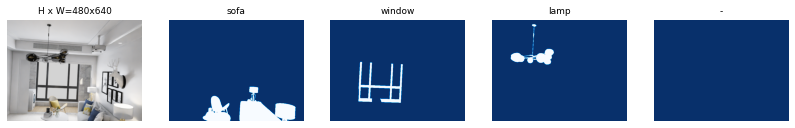

54490


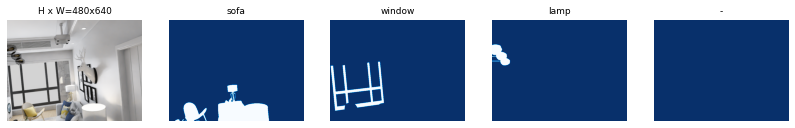

In [8]:
image_ids = dataset_train.load_view(2)
print(image_ids)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    print(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [43]:
class TrainConfig(interior_seq.InteriorNetConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    STEPS_PER_EPOCH = 1000
    VALIDATION_STEPS = 10
    NUM_CLASSES = len(selected_classes)  # background + num classes
    vmin = -5.
    vmax = 5.
    grid_dist = 5.
    nvox = 100
    nvox_z = 100
    vsize = float(vmax - vmin) / nvox
    vox_bs = 1
    im_bs = 1
    samples = 50
    min_z = 1000
    max_z = 1000
    NUM_VIEWS = 2
    RECURRENT = False
    USE_RPN_ROIS = True
    DETECTION_MIN_CONFIDENCE = 0.0
    GRID_REAS = 'ident'
    
config = TrainConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
GRID_REAS                      ident
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  640
IMAGE_META_SIZE                36
IMAGE_MIN_DIM                  640
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [640 640   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE      

In [10]:
import json
with open(os.path.join(ROOT_DIR,'data/InteriorNet/data/HD7/train/instance_mapping.json')) as json_file:
    instance_map = json.load(json_file)
#print(instance_map)

In [11]:
instance = np.random.choice(list(instance_map.keys()),1)[0]

obj_inst = np.asarray(instance_map[instance])
print(obj_inst.shape)
views = np.random.choice(range(obj_inst.shape[0]),2)
print(views)
image_ids = obj_inst[views][:,1]
print(image_ids)
#print(dataset_train.image_from_source_map)
print(dataset_train.load_view(2))

(13, 2)
[7 3]
['3FO4MMDBVKJ0_Bedroom_id15' '3FO4MMDBVKJ0_Bedroom_id12']
3FO4MMLCRTM9_Living_room_id15
[1149, 1147]


In [44]:
# obj_inst = np.array(instance_map['17'])
# image_ids = obj_inst[0:config.NUM_VIEWS][:,1]
# # image_ids = [obj_inst[0][1], obj_inst[20][1]]
# image_ids = np.random.choice(dataset_train.image_ids, config.NUM_VIEWS*1)
image_ids = np.array(dataset_train.load_view(2))
# image_ids = np.array([300, 301])

image_pairs = image_ids.reshape([-1,config.NUM_VIEWS])
print(image_ids)
im = []
Rcam = []
print([config.NUM_VIEWS] + list(config.IMAGE_SHAPE))
# for image_id in image_ids:
#     image_id = dataset_train.image_from_source_map["interior.33FO4JXILITSO_id"+image_id]
#     image = dataset_train.load_image(image_id)
#     image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
#     im.append(image)
#     Rcam.append(dataset_train.load_R(image_id))
for image_pair in image_pairs:
    im = []
    Rcam = []
    Kmat = dataset_train.K
    for image_id in image_pair:
        image = dataset_train.load_image(image_id)
        image, _, _, _, _ = utils.resize_image(image, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
        im.append(image)
        Rcam.append(dataset_train.load_R(image_id))
    im = np.stack(im)
    Rcam = np.stack([Rcam])
    Kmat = np.stack([Kmat])
    print(im.shape)
    print(Rcam.shape)
    print(Kmat.shape)


# Free Memory
del image

from keras.backend.tensorflow_backend import set_session
config_tf = tf.ConfigProto()
config_tf.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config_tf.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config_tf)
set_session(sess)  # set this TensorFlow session as the default session for Keras
model = projection1.ProjectionNet(config)
im_res, grid = model.run([[im], Rcam, Kmat])
tf.reset_default_graph()
del model
del sess

3FO4MLTARDRD_Living_room_id11
[62092 62085]
[2, 640, 640, 3]
(2, 640, 640, 3)
(1, 2, 3, 4)
(1, 3, 3)
Tensor("lambda_1/Tile:0", shape=(?,), dtype=int32)
shape of Kmat: [None, None, 3, 3]
shape of Rcam: [None, 3, 4]
grid position shape: [1, 3]
grid shape: [4, 1000000]
Tensor("lambda_1/Tile_4:0", shape=(?,), dtype=int32)
shape of Kmat: [None, None, 3, 3]
shape of Rcam: [None, 3, 4]
grid position shape: [1, 3]
grid shape: [4, 1000000]
Grid_shape grid_reas: [1, None, 100, 100, 100, 3]
Grid_shape grid_reas2: [1, None, 100, 100, 100, 3]
Grid_shape after reshape: [1, 100, 100, 100, 6]
Grid_shape grid_reas_end: [1, 100, 100, 100, 3]
Grid_shape grid_reas: [1, None, 100, 100, 100, 3]
Grid_shape grid_reas2: [1, None, 100, 100, 100, 3]
Grid_shape after reshape: [1, 100, 100, 100, 6]
Grid_shape grid_reas_end: [1, 100, 100, 100, 3]


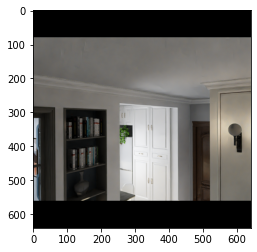

In [45]:
plt.imshow(im[1])
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/original.png'), im[1][:,:,::-1])

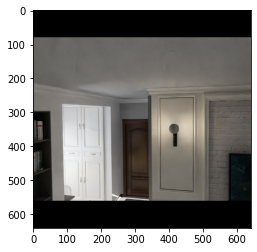

In [46]:
plt.imshow(im[0])

(1, 50, 100, 100, 3)


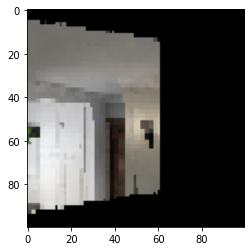

In [57]:
print(im_res.shape)
im_resized, _, _, _, _ = utils.resize_image(im_res[0,25,:,:,:]/255, min_dim=config.IMAGE_MIN_DIM, max_dim=config.IMAGE_MAX_DIM, mode="square")
# get_ax(size=4)
# plt.imshow(np.absolute(im[0]/255-im_resized))
get_ax(size=4)
plt.imshow(im_res[0,0,:,:,:]/255)


In [33]:
# cv2.imwrite(os.path.join(ROOT_DIR,'data/InteriorNet/Results/unproj/proj.png'), im_res[0,0,:,:,::-1])

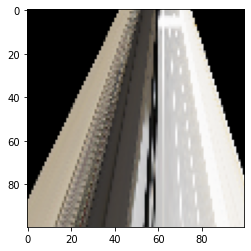

In [17]:
plt.imshow(grid[0,50,:,:,:]/255)